In [46]:
import os
os.chdir("/Users/sanjanakotha/Desktop/Staller_Lab/consensus_predictor/notebooks")

import pandas as pd
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm



# New approach:

1. Z-score PADI
2. Z-score GCN4
3. GCN4 Z-score –linear regression→ controls library alone Z-scores 
4. controls library alone Z-scores –linear regression→ synthetics Z-scores
5. Compare all to
    - Sog1 Sort 2 Ratio
    - Sog1 Sort 2 GFP

Downloading controls only sort results from
/global/scratch/projects/fc_mvslab/OpenProjects/Marissa/SynADs/2024-09-00_w.Ctrls_Medias/DataFiles/Controls_data.csv

In [47]:
## PADI
padi = pd.read_excel("../data/41586_2024_7707_MOESM2_ESM.xlsx")
padi = padi[["Fragment Sequence", "PADI Score"]]
padi = padi.rename(columns = {"Fragment Sequence" : "seq", "PADI Score": "score"})
padi["screen"] = "padi"
padi["seq"] = padi["seq"].str.strip().str.upper()
padi = padi.drop_duplicates(subset = "seq")
padi = padi.dropna()
display(padi)

## GCN4
gcn4 = pd.read_csv("../data/Table_S5_Tile_Activities_Properties_Dataframe.csv")
gcn4 = gcn4[["ADseq", "Activity_SCglucose"]]
gcn4 = gcn4.rename(columns = {"ADseq" : "seq", "Activity_SCglucose": "score"})
gcn4["seq"] = gcn4["seq"].str.strip().str.upper()
gcn4["screen"] = "gcn4"
gcn4 = gcn4.drop_duplicates(subset = "seq").dropna()
display(gcn4)

## Synthetics + controls
# Threshold = 0.057436713684575334 for std
# 19,530 for activity
controls_syn = pd.read_csv("../data/SynAD_Glu_Filtered_ActivityCtrlStd_replicateactivities_simpleave.csv")
# sns.scatterplot(data = controls_syn, x = "Activity", y = "StdActivity")
# plt.axhline(0.05)
controls_syn = controls_syn.rename(columns = {"AAseq" : "seq", "Activity" : "score"})
controls_syn = controls_syn[["seq", "score"]]
controls_syn["seq"] = controls_syn["seq"].str.strip().str.upper()
controls_syn["screen"] = "controls_syn"
controls_syn = controls_syn.drop_duplicates(subset = "seq")
display(controls_syn)

# negative_controls = pd.read_csv("../data/negative_controls.csv")
# display(negative_controls)

,seq,score,screen
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,1.004699,padi
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,0.575876,padi
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,-0.300407,padi
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,0.105372,padi
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,-0.167147,padi
...,...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,-0.139281,padi
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,-0.064551,padi
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,-0.410777,padi
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,0.329820,padi


,seq,score,screen
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,50849.75654,gcn4
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,22153.46439,gcn4
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,25911.89042,gcn4
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,22446.77365,gcn4
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,51501.39821,gcn4
...,...,...,...
20726,AKVDTEEEDKTMVDSTSLSWEDLFDFESYSTDLIASINPD,261829.75160,gcn4
20727,STDYTPMFEYETYEDNFKEWTSLFDNDIPVTTDDVSLADR,261410.70530,gcn4
20728,MTDSTPMFEYELTENNSKEWTSLFDTDIPVTTDDESLADK,152798.87030,gcn4
20729,STDSTPMFEYQNLENNSKEWTSLFDNDIPVTTDNVSLADK,113197.55830,gcn4


,seq,score,screen
0,AAAAAIACELRTDNYFEYPDLSILDALDNDSDETMSLIDE,25075.335066,controls_syn
1,AAAAASDHSDVNDIIELGGLSNRLYDFYSDLEDIENDIAV,42429.450978,controls_syn
2,AAADGASFSDDTDEDLYKYDPWDLPGLSVIKTDDPEWFFF,167550.966119,controls_syn
3,AAADGASFSDDTDEDLYKYDPWELPSKASFGEQEWYFFSP,109426.029848,controls_syn
4,AAADGPDCDTREFCELRDSLLWNESCFLLDDDKRFDVSEN,56143.316707,controls_syn
...,...,...,...
17265,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,254716.006477,controls_syn
17266,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,237618.847801,controls_syn
17267,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,46055.201492,controls_syn
17268,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,141711.824042,controls_syn


In [48]:
## Controls only
controls = pd.read_csv("../data/Controls_data.csv")
controls = controls.rename(columns = {"AAseq" : "seq", "Activity" : "score"})
controls = controls[["seq", "score"]]
controls["seq"] = controls["seq"].str.strip().str.upper()
controls = controls.groupby("seq").mean()
controls["screen"] = "controls"
controls = controls.reset_index()
controls.columns = ["seq", "score", "screen"]
controls = controls.drop_duplicates(subset = "seq")
display(controls)


,seq,score,screen
0,AAEPNYGSVAISLPLERTISSQSMERSGSSSSGSPVVLDG,8703.989803,controls
1,AAIALSQPETIPAKEISVPPSPAVGKSASPAPSPAPSKSG,7357.157905,controls
2,AAIPENELLDEDTMNAISSLKNDLSNISNSLPAEAPHEIA,14912.682565,controls
3,AALDVALALSQPETKPAKEVSVPPSPAIRNSASPAPSPAP,8839.884407,controls
4,AAVVESFFSSSADSTPMFEYENLEDNSKEWTSLFDNDIPV,252224.680582,controls
...,...,...,...
492,YKMQQEQNMKTFDPEVAFEEWFLSTDYQGLPSDFSPLTGV,259411.961204,controls
493,YPSTPHPQPRLRVPVKATHRPSALQPFLAQNNPRRHSFNL,9030.547980,controls
494,YRSQSVSTQRRSATSGVRKRQPLPPIVVEDPSDTVAMKRA,9198.535282,controls
495,YSLFDSPSEGYETSPLFNTNDDLDDSNGWYSLFPPTTTSS,244362.069960,controls


In [49]:
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture

def fit_inactive_gaussian_to_all_data(df, active_threshold = 1, mu = False, sigma = False, title = False, supylabel_x = 0):
    # fig, axs = plt.subplots(4, 1,  figsize=(8, 4), dpi = 300)

    fig = plt.figure(dpi=300, figsize=(8, 6))

    # First three subplots share x-axis
    ax1 = plt.subplot(4, 1, 1)
    ax2 = plt.subplot(4, 1, 2, sharex=ax1)
    ax3 = plt.subplot(4, 1, 3, sharex=ax1)
    # Fourth one does not share x
    ax4 = plt.subplot(4, 1, 4)

    # Now you can access them as a list if needed
    axs = [ax1, ax2, ax3, ax4]
    
    # Optional: Hide x tick labels for the first two so they don't repeat
    # plt.setp(ax1.get_xticklabels(), visible=False)
    # plt.setp(ax2.get_xticklabels(), visible=False)
    # plt.setp(ax3.get_xticklabels(), visible=True)

    scores = np.array(df["score"]) 
    
    if mu == False and sigma == False:
        

        # Make histogram to identify peak of density
        hist, bin_edges = np.histogram(scores, bins=100)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Find location of histogram peak
        peak_index = np.argmax(hist)
        peak_location = bin_centers[peak_index]

        # # Estimate density using KDE fit to first 75% of data
        # kde = gaussian_kde(scores[scores < np.percentile(scores, 95)])
        # x_vals = np.linspace(min(scores), max(scores), 1000)
        # kde_vals = kde(x_vals)

        # # Find KDE peak location
        # peak_index = np.argmax(kde_vals)
        # peak_location = x_vals[peak_index]
        # axs[2].axvline(peak_location, color = 'red', linestyle = 'dashed', lw = 1)
       
        # gmm = GaussianMixture(n_components=8).fit(scores.reshape(-1, 1))
        # peak_location = gmm.means_.min()

        # Use interval from 1st percentile of scores to histogram peak to determine threshold
        width_before_peak = peak_location - np.percentile(scores, 1)
        threshold = peak_location + np.abs(width_before_peak)

        # # Plot threshold
        sns.histplot(scores, bins = 500, ax = axs[0], stat = 'density', kde = True)
        axs[0].axvline(active_threshold)

        #sns.lineplot(x = x_vals, y = kde_vals, ax = ax0_twin, color = 'red')
        
        sns.histplot(scores, bins = 500, ax = axs[1], stat = 'density', kde = True)
        axs[1].axvline(peak_location, color = 'red', linestyle = 'dashed')
        #axs[0].axvspan(min(scores), np.percentile(scores, 1), color = 'gray', alpha = 0.5, lw = 0)
        axs[1].axvspan(threshold, max(scores), color = 'gray', alpha = 0.5, lw = 0)

        # Fit a gaussian to the inactive scores
        inactive_scores = scores[scores < threshold]
        mu, sigma = norm.fit(inactive_scores)

    # Plot the histogram and fitted Gaussian
    sns.histplot(scores, stat = 'density', bins = 500, ax=axs[2])
    x = np.linspace(min(scores), max(scores), 100)
    ax2 = axs[2].twinx()  # Update to use axs[1]
    ax2.plot(x, norm.pdf(x, mu, sigma), 'r-', label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}', color = 'red')
    ax2.set_ylim(0, None)
    sns.despine()

    df["z-score"] = (df["score"] - mu) / sigma
    print(mu, sigma)
    print("New threshold:")
    new_threshold = (active_threshold - mu) / sigma
    print(new_threshold)

    sns.histplot(df["z-score"], bins = 500, ax = axs[3], stat = "density")
    axs[3].axvline(5, color = 'red')
    axs[3].axvline(new_threshold)

    fig.tight_layout(pad = 0)

    if title:
        plt.suptitle(title, va = 'bottom', y = 1.01)
        
    for ax in axs:
        ax.set_ylabel("")

    fig.supylabel("Density", x= supylabel_x)
    
    return df, new_threshold



# 1. Z-Score PADI

/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_18182/1832853416.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(x, norm.pdf(x, mu, sigma), 'r-', label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}', color = 'red')


-0.32601666767861776 0.2557339776776899
New threshold:
5.185140745551774


,seq,score,screen,z-score
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,1.004699,padi,5.203514
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,0.575876,padi,3.526685
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,-0.300407,padi,0.100141
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,0.105372,padi,1.686865
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,-0.167147,padi,0.621230
...,...,...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,-0.139281,padi,0.730194
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,-0.064551,padi,1.022412
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,-0.410777,padi,-0.331438
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,0.329820,padi,2.564526


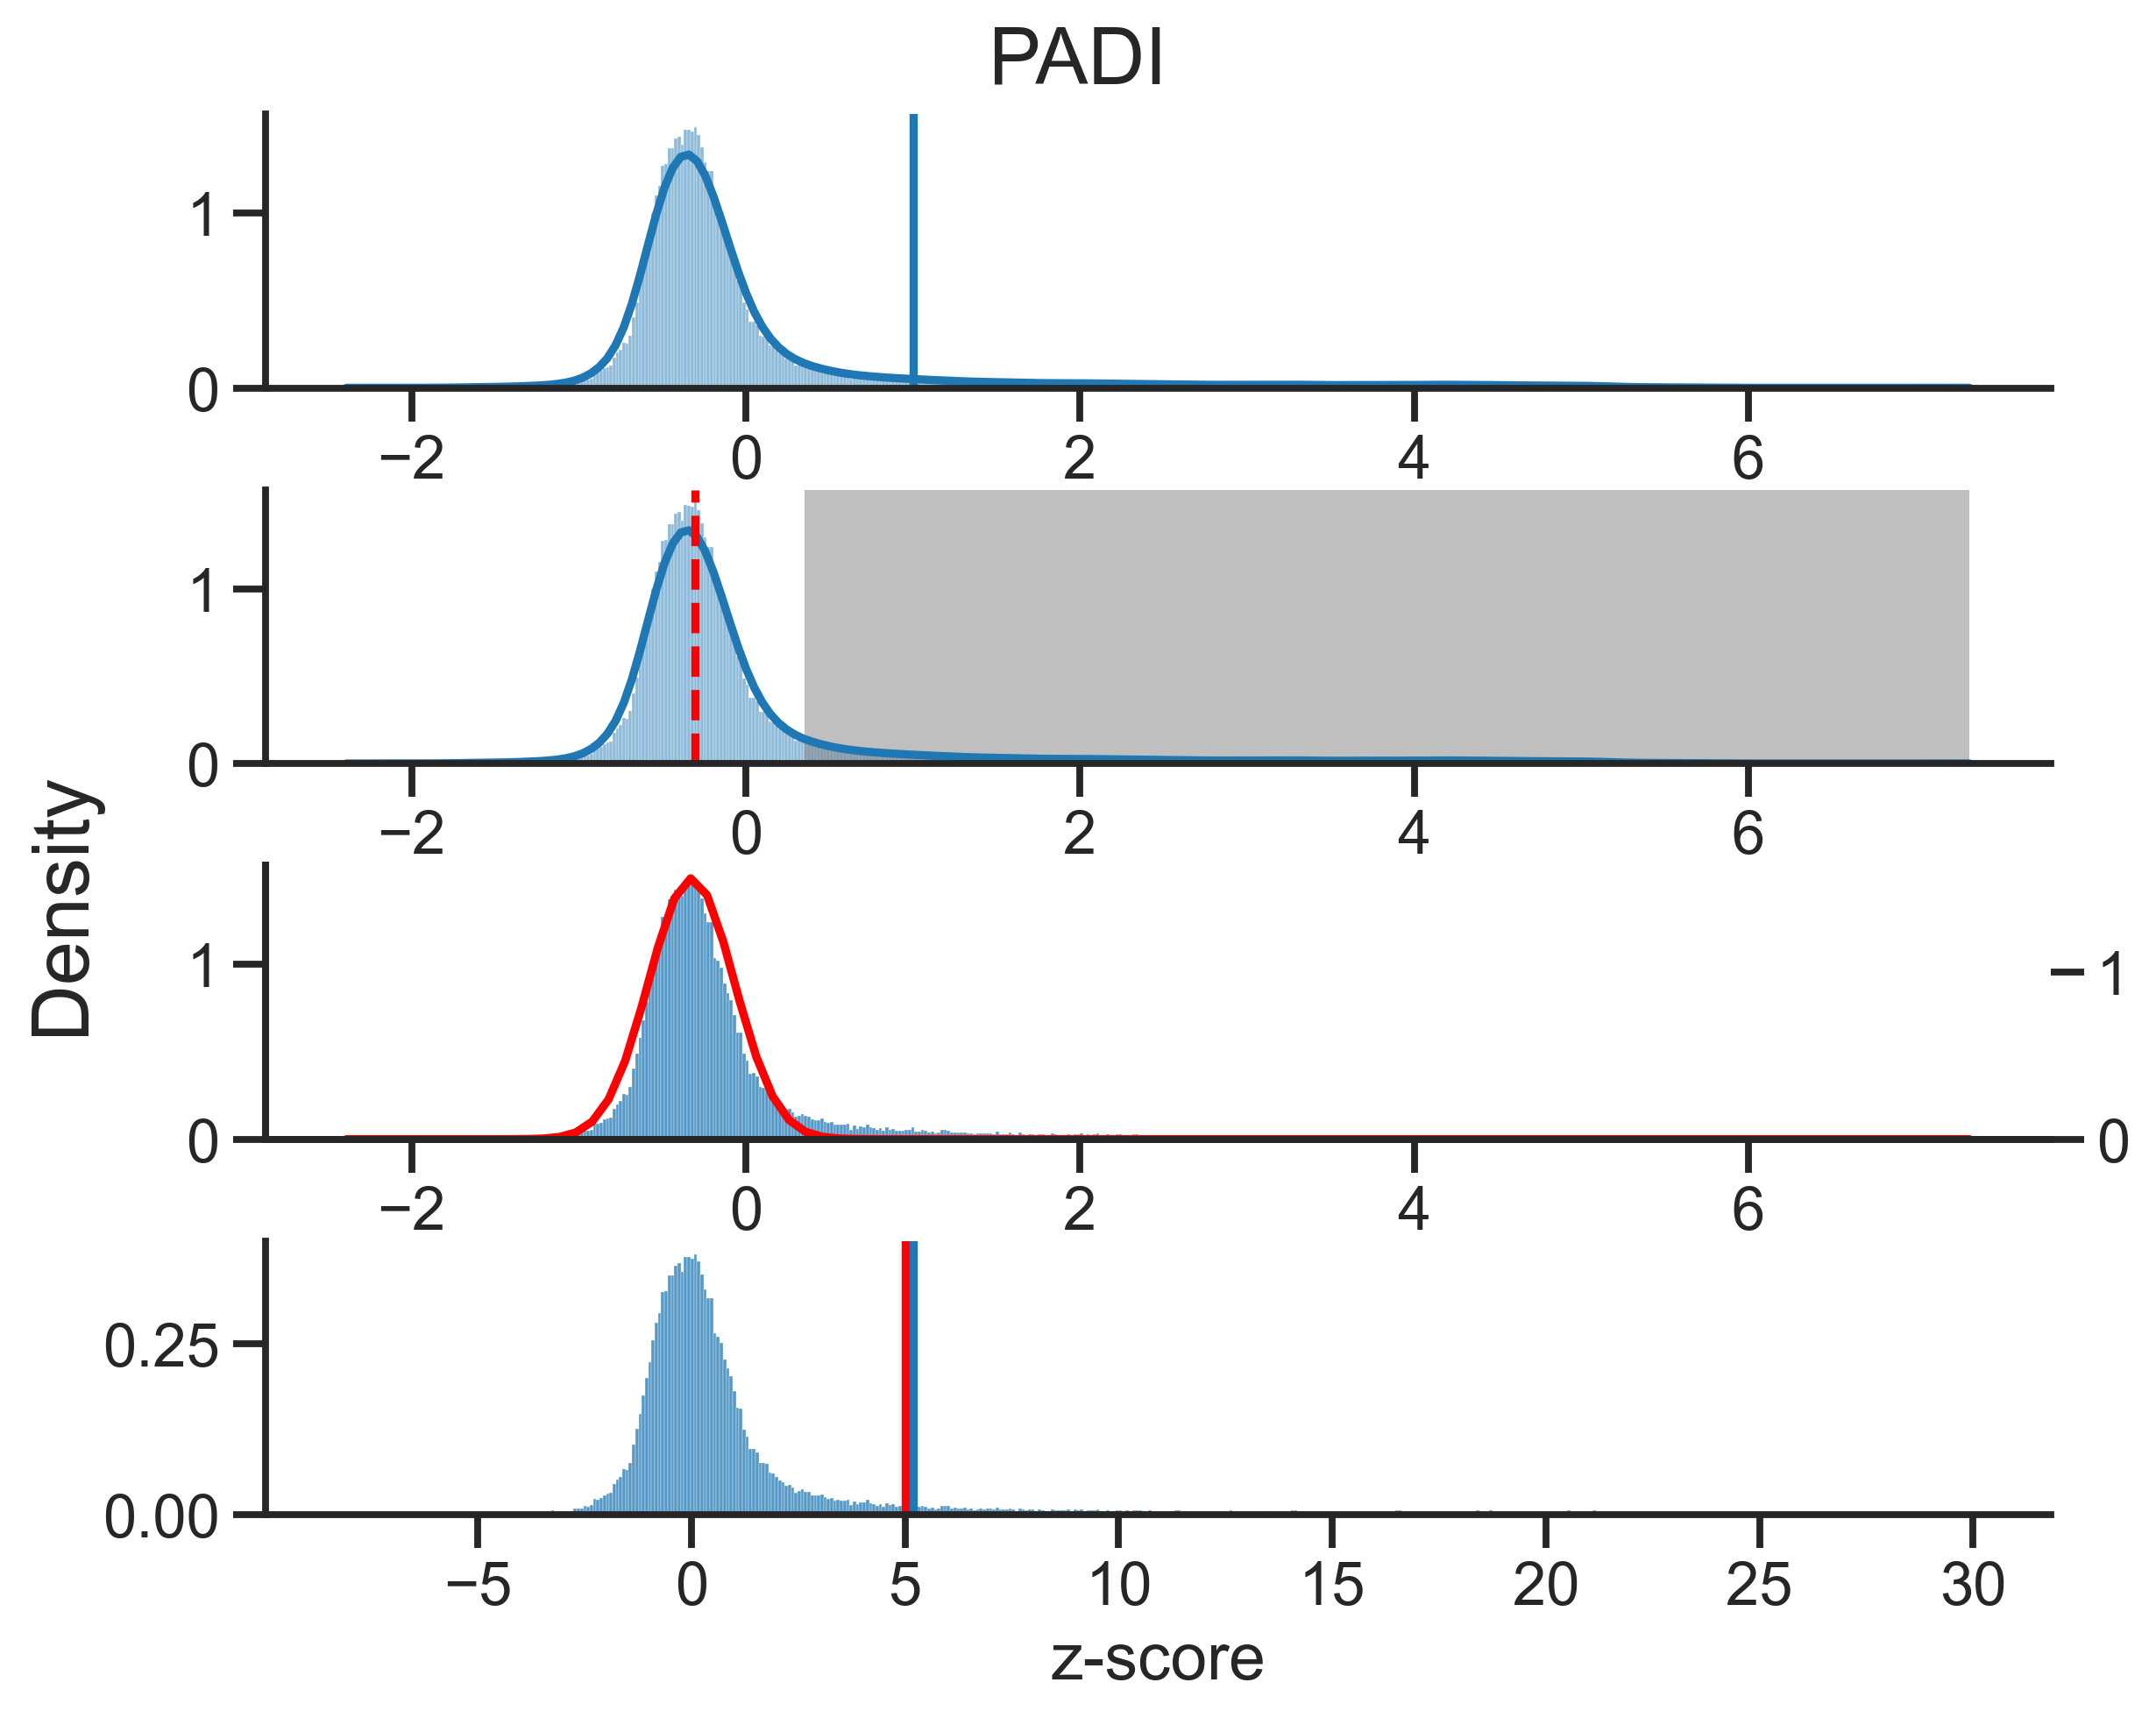

In [50]:
padi, padi_threshold = fit_inactive_gaussian_to_all_data(padi, 1, title = "PADI")
padi


# 2. Z-score GCN4

In [51]:
(50076 - 21000) / 5800

5.013103448275862

In [52]:
5 * 5804 + 21056

50076

21056.77266137553 5804.037567721136
New threshold:
13.601432867640844


/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_18182/1832853416.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(x, norm.pdf(x, mu, sigma), 'r-', label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}', color = 'red')


,seq,score,screen,z-score
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,50849.75654,gcn4,5.133148
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,22153.46439,gcn4,0.188953
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,25911.89042,gcn4,0.836507
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,22446.77365,gcn4,0.239489
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,51501.39821,gcn4,5.245422
...,...,...,...,...
20726,AKVDTEEEDKTMVDSTSLSWEDLFDFESYSTDLIASINPD,261829.75160,gcn4,41.483704
20727,STDYTPMFEYETYEDNFKEWTSLFDNDIPVTTDDVSLADR,261410.70530,gcn4,41.411505
20728,MTDSTPMFEYELTENNSKEWTSLFDTDIPVTTDDESLADK,152798.87030,gcn4,22.698354
20729,STDSTPMFEYQNLENNSKEWTSLFDNDIPVTTDNVSLADK,113197.55830,gcn4,15.875291


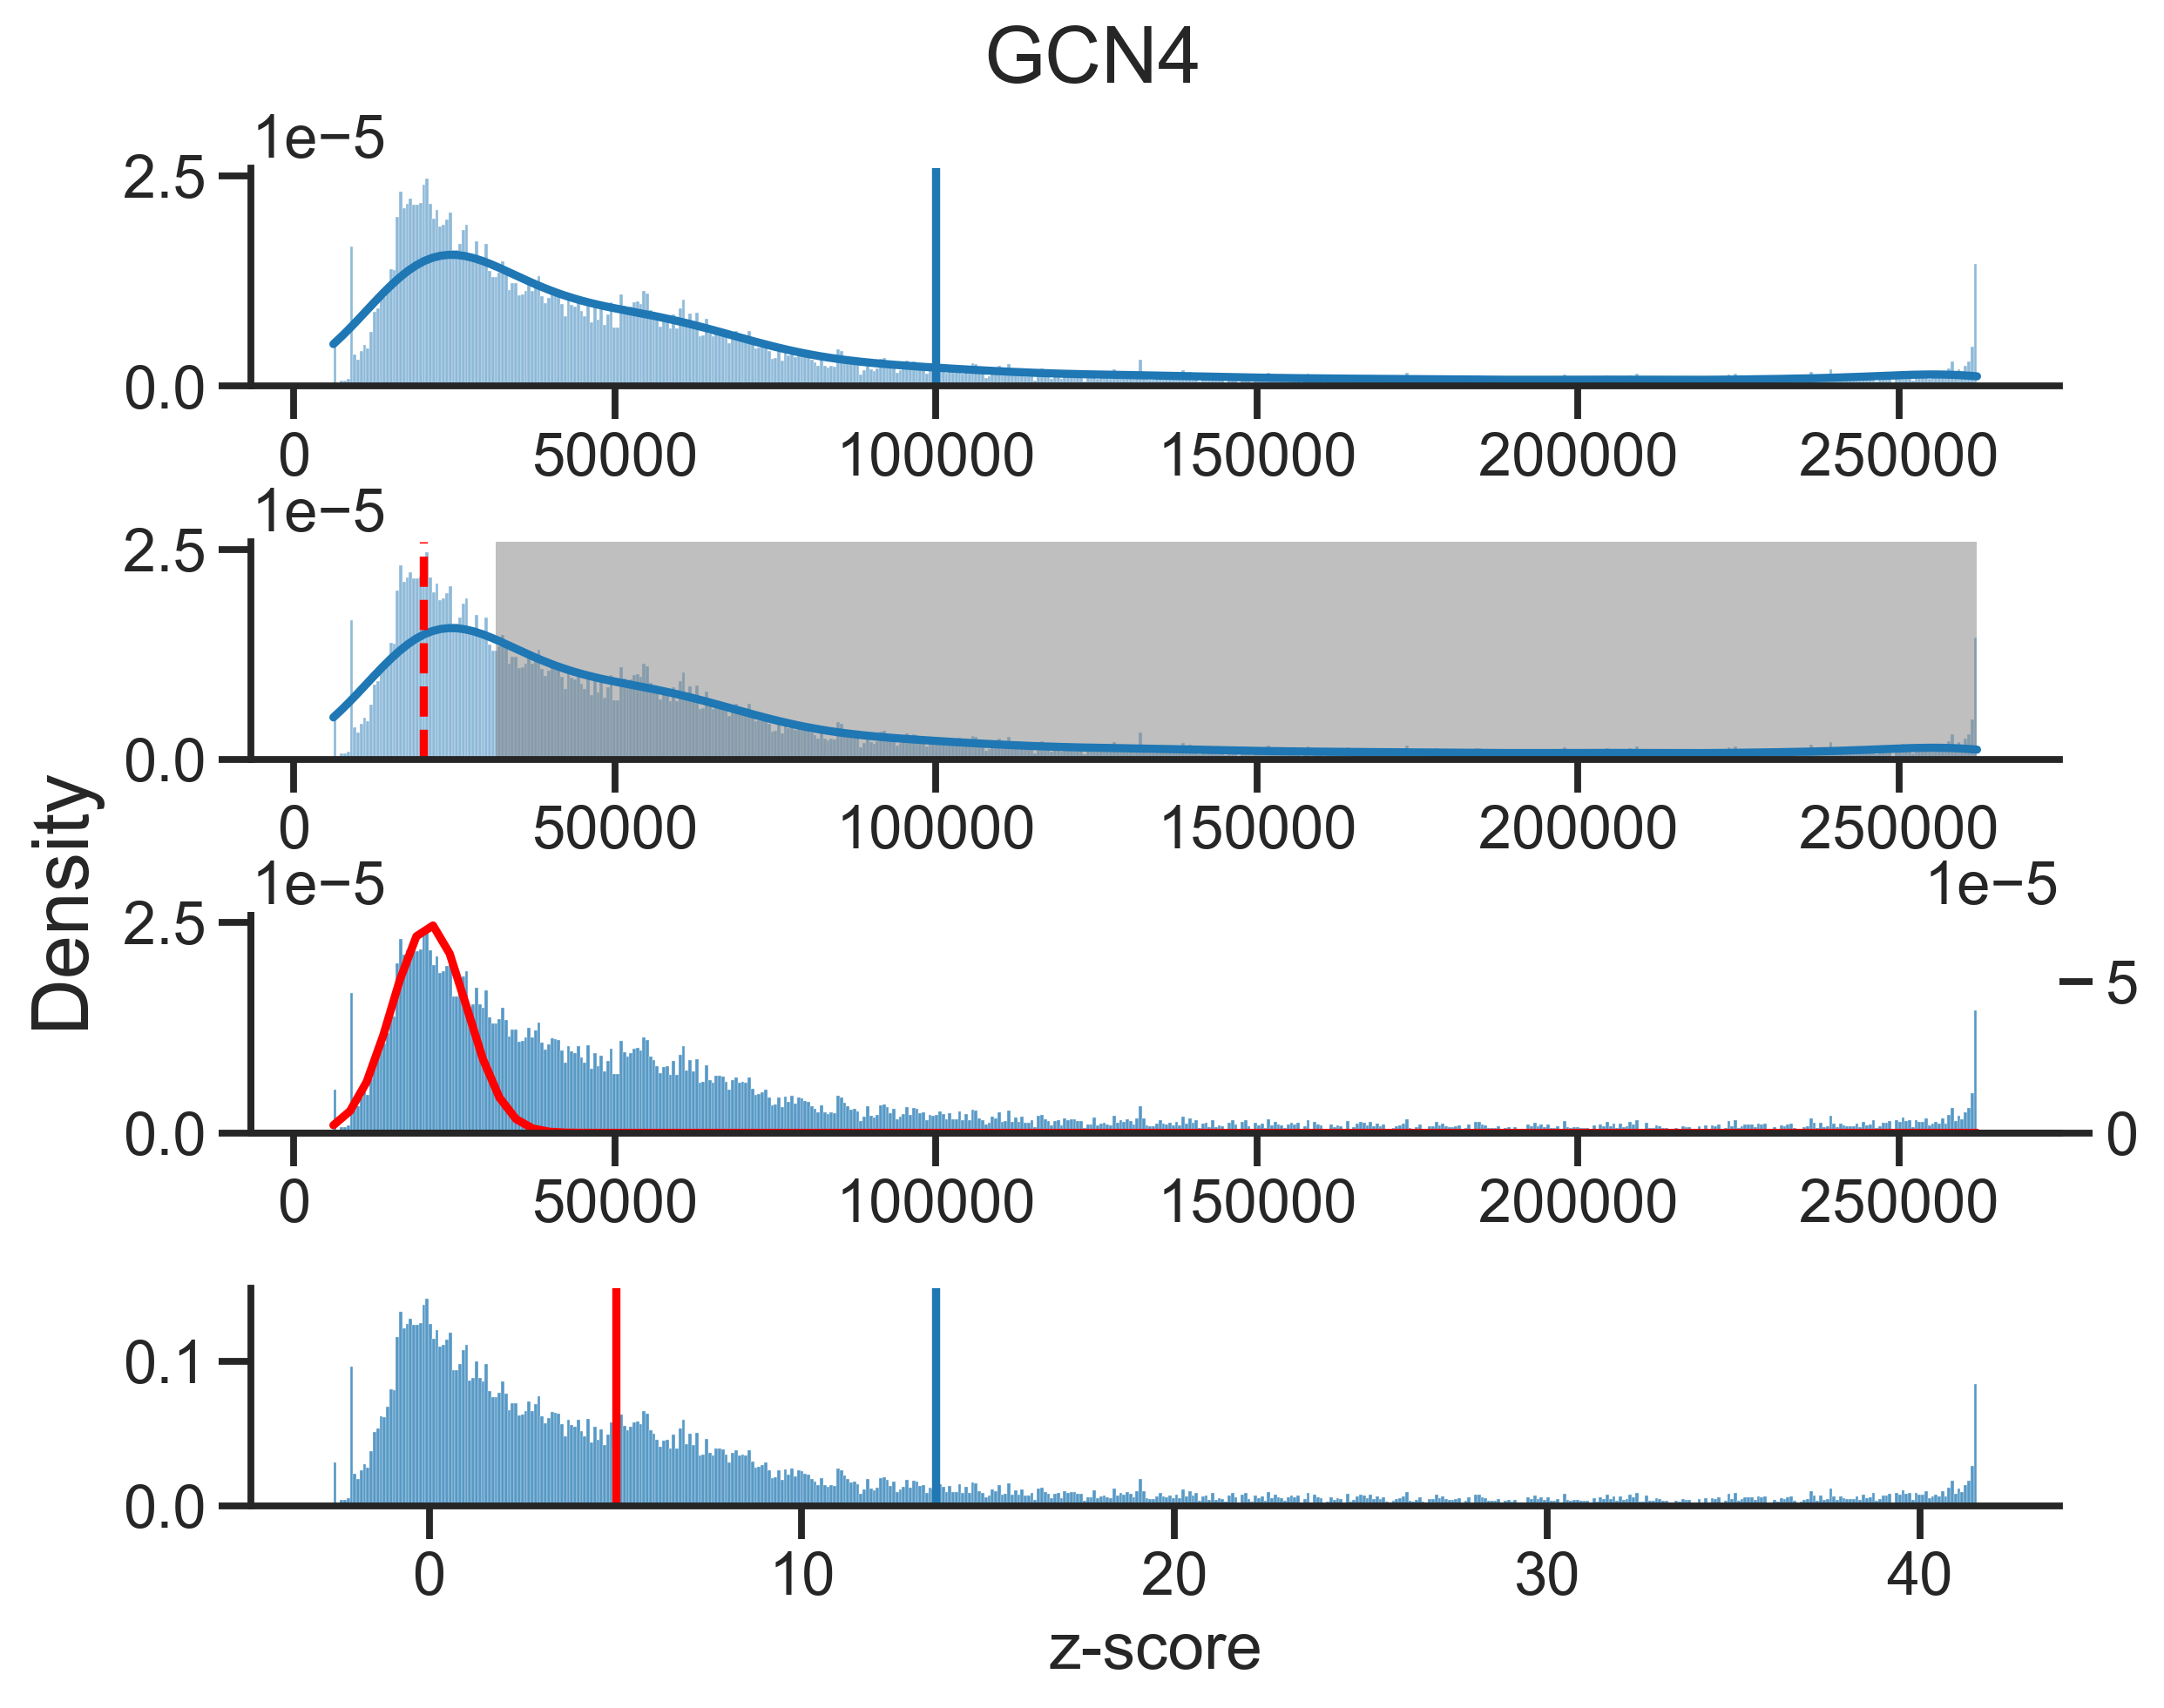

In [53]:
gcn4, gcn4_threshold = fit_inactive_gaussian_to_all_data(gcn4, 100000, title = "GCN4", supylabel_x = -0.01)
gcn4


# 3. GCN4 Z-score –linear regression→ controls library alone Z-scores 

## 3A. First check are controls well correlated between controls library alone and Synthetics/GCN4?

In [54]:
controls_controls_syn = pd.merge(controls, controls_syn, on = "seq", suffixes = ("_controls_alone", "_controls_with_synthetics"))
controls_controls_syn

,seq,score_controls_alone,screen_controls_alone,score_controls_with_synthetics,screen_controls_with_synthetics
0,AAEPNYGSVAISLPLERTISSQSMERSGSSSSGSPVVLDG,8703.989803,controls,5639.517210,controls_syn
1,AAIALSQPETIPAKEISVPPSPAVGKSASPAPSPAPSKSG,7357.157905,controls,4815.867766,controls_syn
2,AAIPENELLDEDTMNAISSLKNDLSNISNSLPAEAPHEIA,14912.682565,controls,15854.361914,controls_syn
3,AALDVALALSQPETKPAKEVSVPPSPAIRNSASPAPSPAP,8839.884407,controls,5231.704055,controls_syn
4,AAVVESFFSSSADSTPMFEYENLEDNSKEWTSLFDNDIPV,252224.680582,controls,239156.047588,controls_syn
...,...,...,...,...,...
492,YKMQQEQNMKTFDPEVAFEEWFLSTDYQGLPSDFSPLTGV,259411.961204,controls,248346.156256,controls_syn
493,YPSTPHPQPRLRVPVKATHRPSALQPFLAQNNPRRHSFNL,9030.547980,controls,6427.793208,controls_syn
494,YRSQSVSTQRRSATSGVRKRQPLPPIVVEDPSDTVAMKRA,9198.535282,controls,6050.175447,controls_syn
495,YSLFDSPSEGYETSPLFNTNDDLDDSNGWYSLFPPTTTSS,244362.069960,controls,202363.268857,controls_syn


In [55]:
controls_controls_syn_gcn4 = pd.merge(controls_controls_syn, gcn4)
controls_controls_syn_gcn4 = controls_controls_syn_gcn4.rename(columns = {"score_controls_alone": "controls_alone",
                                                                          "score_controls_with_synthetics" : "with_synthetics",
                                                                          "score" : "with_gcn4"})
controls_controls_syn_gcn4

,seq,controls_alone,screen_controls_alone,with_synthetics,screen_controls_with_synthetics,with_gcn4,screen,z-score
0,AAEPNYGSVAISLPLERTISSQSMERSGSSSSGSPVVLDG,8703.989803,controls,5639.517210,controls_syn,16569.29690,gcn4,-0.773164
1,AAIALSQPETIPAKEISVPPSPAVGKSASPAPSPAPSKSG,7357.157905,controls,4815.867766,controls_syn,14994.83033,gcn4,-1.044435
2,AAIPENELLDEDTMNAISSLKNDLSNISNSLPAEAPHEIA,14912.682565,controls,15854.361914,controls_syn,36628.05513,gcn4,2.682836
3,AALDVALALSQPETKPAKEVSVPPSPAIRNSASPAPSPAP,8839.884407,controls,5231.704055,controls_syn,18454.75802,gcn4,-0.448311
4,AAVVESFFSSSADSTPMFEYENLEDNSKEWTSLFDNDIPV,252224.680582,controls,239156.047588,controls_syn,257460.75220,gcn4,40.730953
...,...,...,...,...,...,...,...,...
474,YKMQQEQNMKTFDPEVAFEEWFLSTDYQGLPSDFSPLTGV,259411.961204,controls,248346.156256,controls_syn,261912.60730,gcn4,41.497980
475,YPSTPHPQPRLRVPVKATHRPSALQPFLAQNNPRRHSFNL,9030.547980,controls,6427.793208,controls_syn,16772.86384,gcn4,-0.738091
476,YRSQSVSTQRRSATSGVRKRQPLPPIVVEDPSDTVAMKRA,9198.535282,controls,6050.175447,controls_syn,17071.81293,gcn4,-0.686584
477,YSLFDSPSEGYETSPLFNTNDDLDDSNGWYSLFPPTTTSS,244362.069960,controls,202363.268857,controls_syn,257835.53940,gcn4,40.795526


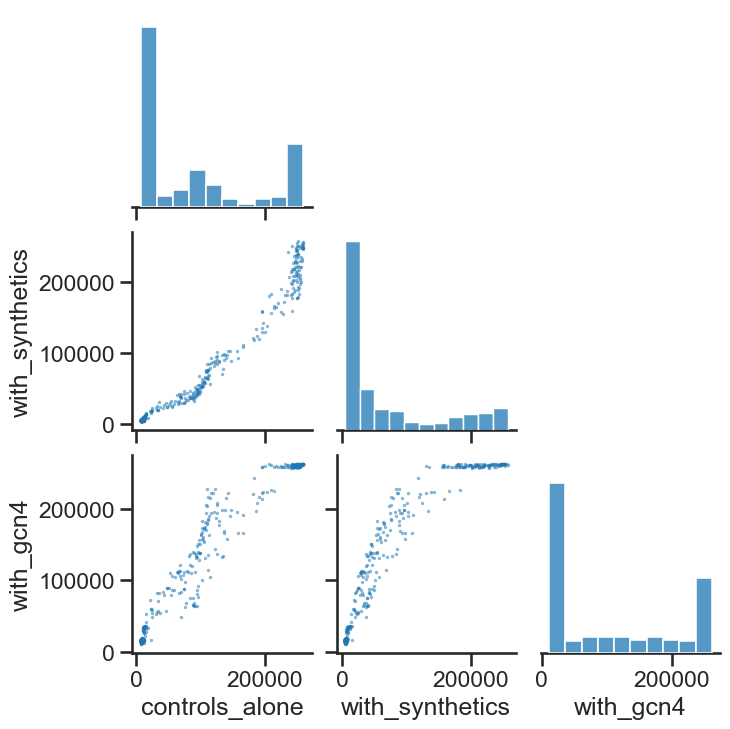

In [56]:
sns.pairplot(
    controls_controls_syn_gcn4[["controls_alone", "with_synthetics", "with_gcn4"]],
    plot_kws={'s': 5, 'alpha': 0.5, 'edgecolor': None}, corner = True
)

## 3B. GCN4 z score to controls z score

In [57]:
gcn4_controls_only = pd.merge(gcn4, controls, suffixes = ("_gcn4", "_controls_only"), on = "seq")
gcn4_controls_only

,seq,score_gcn4,screen_gcn4,z-score,score_controls_only,screen_controls_only
0,ASGQANANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDH,31637.98609,gcn4,1.823078,11583.254626,controls
1,NANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDHSAQRG,35182.01274,gcn4,2.433692,11056.275462,controls
2,NIAATGPAIAPSQAPAIGGPSALGQYGPNPFVPAAYHYPA,42551.71009,gcn4,3.703446,14887.892036,controls
3,DALSSSSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAA,13333.59766,gcn4,-1.330656,8502.833832,controls
4,SSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAARQLLE,14917.38884,gcn4,-1.057778,7776.232326,controls
...,...,...,...,...,...,...
474,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,17261.58387,gcn4,-0.653888,7943.796987,controls
475,PPTDVSLGDELHLDGEDVAMAHADALDDADLDMLGDGDSP,32720.43454,gcn4,2.009577,9815.370149,controls
476,PPTDVSAGDEAHADGEDVAMAHADAADDADADMAGDGDSP,14676.81276,gcn4,-1.099228,7573.698567,controls
477,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDF,262003.24940,gcn4,41.513597,259277.072990,controls


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,seq,score,screen,gcn4_z-score
0,AAEPNYGSVAISLPLERTISSQSMERSGSSSSGSPVVLDG,8703.989803,controls,-0.112582
1,AAIALSQPETIPAKEISVPPSPAVGKSASPAPSPAPSKSG,7357.157905,controls,-0.402707
2,AAIPENELLDEDTMNAISSLKNDLSNISNSLPAEAPHEIA,14912.682565,controls,1.224850
3,AALDVALALSQPETKPAKEVSVPPSPAIRNSASPAPSPAP,8839.884407,controls,-0.083309
4,AAVVESFFSSSADSTPMFEYENLEDNSKEWTSLFDNDIPV,252224.680582,controls,52.344895
...,...,...,...,...
492,YKMQQEQNMKTFDPEVAFEEWFLSTDYQGLPSDFSPLTGV,259411.961204,controls,53.893128
493,YPSTPHPQPRLRVPVKATHRPSALQPFLAQNNPRRHSFNL,9030.547980,controls,-0.042237
494,YRSQSVSTQRRSATSGVRKRQPLPPIVVEDPSDTVAMKRA,9198.535282,controls,-0.006051
495,YSLFDSPSEGYETSPLFNTNDDLDDSNGWYSLFPPTTTSS,244362.069960,controls,50.651188


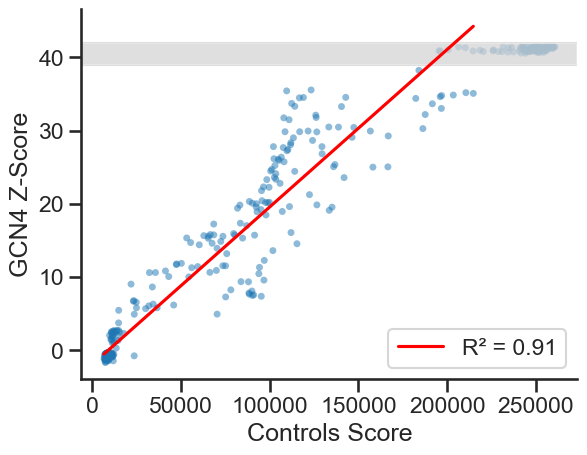

In [58]:
sns.scatterplot(data=gcn4_controls_only, x="score_controls_only", y="z-score", alpha=0.5, edgecolor='none', s=25)
plt.xlabel("Controls Score")
plt.ylabel("GCN4 Z-Score")

# plt.axhspan(min(gcn4_controls_only["z-score"]) - 0.5, min(gcn4_controls_only["z-score"]) + 4.5, color='gray', alpha=0.5)
# plt.axhspan(min(gcn4_controls_only["z-score"]) - 0.5, min(gcn4_controls_only["z-score"]) + 4.5, color='white', alpha=0.5)

plt.axhspan(max(gcn4_controls_only["z-score"]) - 2.5, max(gcn4_controls_only["z-score"]) + 0.5, color='gray', alpha=0.5)
plt.axhspan(max(gcn4_controls_only["z-score"]) - 2.5, max(gcn4_controls_only["z-score"]) + 0.5, color='white', alpha=0.5)

linear_region = gcn4_controls_only[
    #(gcn4_controls_only["z-score"] > min(gcn4_controls_only["z-score"]) + 5) &
    (gcn4_controls_only["z-score"] < max(gcn4_controls_only["z-score"]) - 2)
]

# Fit linear regression model to predict z-score from controls score
model = LinearRegression()
X = linear_region[["score_controls_only"]].values.reshape(-1, 1)
y = linear_region["z-score"].values
model.fit(X, y)

# Predict and evaluate
predictions = model.predict(X)
r2 = r2_score(y, predictions)

# Plot regression line
sns.lineplot(x=linear_region["score_controls_only"], y = predictions, color="red", label=f"R² = {r2:.2f}")
plt.legend()

sns.despine()
gcn4_controls_only["controls_only_z-score"] = model.predict(gcn4_controls_only[["score_controls_only"]])
controls["gcn4_z-score"] = model.predict(controls[["score"]])
controls

# 4. controls library alone Z-scores –linear regression→ synthetics Z-scores

In [59]:
gcn4_controls_only_syn = pd.merge(gcn4_controls_only, controls_syn, on = "seq", suffixes = ("", "_syn"))
gcn4_controls_only_syn

,seq,score_gcn4,screen_gcn4,z-score,score_controls_only,screen_controls_only,controls_only_z-score,score,screen
0,ASGQANANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDH,31637.98609,gcn4,1.823078,11583.254626,controls,0.507648,8930.519463,controls_syn
1,NANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDHSAQRG,35182.01274,gcn4,2.433692,11056.275462,controls,0.394130,8217.768578,controls_syn
2,NIAATGPAIAPSQAPAIGGPSALGQYGPNPFVPAAYHYPA,42551.71009,gcn4,3.703446,14887.892036,controls,1.219510,13961.152719,controls_syn
3,DALSSSSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAA,13333.59766,gcn4,-1.330656,8502.833832,controls,-0.155914,4885.459740,controls_syn
4,SSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAARQLLE,14917.38884,gcn4,-1.057778,7776.232326,controls,-0.312433,4059.300298,controls_syn
...,...,...,...,...,...,...,...,...,...
474,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,17261.58387,gcn4,-0.653888,7943.796987,controls,-0.276337,4861.135792,controls_syn
475,PPTDVSLGDELHLDGEDVAMAHADALDDADLDMLGDGDSP,32720.43454,gcn4,2.009577,9815.370149,controls,0.126823,6479.384414,controls_syn
476,PPTDVSAGDEAHADGEDVAMAHADAADDADADMAGDGDSP,14676.81276,gcn4,-1.099228,7573.698567,controls,-0.356061,6539.294161,controls_syn
477,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDF,262003.24940,gcn4,41.513597,259277.072990,controls,53.864071,249619.965442,controls_syn


In [60]:
gcn4_controls_only_syn

,seq,score_gcn4,screen_gcn4,z-score,score_controls_only,screen_controls_only,controls_only_z-score,score,screen
0,ASGQANANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDH,31637.98609,gcn4,1.823078,11583.254626,controls,0.507648,8930.519463,controls_syn
1,NANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDHSAQRG,35182.01274,gcn4,2.433692,11056.275462,controls,0.394130,8217.768578,controls_syn
2,NIAATGPAIAPSQAPAIGGPSALGQYGPNPFVPAAYHYPA,42551.71009,gcn4,3.703446,14887.892036,controls,1.219510,13961.152719,controls_syn
3,DALSSSSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAA,13333.59766,gcn4,-1.330656,8502.833832,controls,-0.155914,4885.459740,controls_syn
4,SSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAARQLLE,14917.38884,gcn4,-1.057778,7776.232326,controls,-0.312433,4059.300298,controls_syn
...,...,...,...,...,...,...,...,...,...
474,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,17261.58387,gcn4,-0.653888,7943.796987,controls,-0.276337,4861.135792,controls_syn
475,PPTDVSLGDELHLDGEDVAMAHADALDDADLDMLGDGDSP,32720.43454,gcn4,2.009577,9815.370149,controls,0.126823,6479.384414,controls_syn
476,PPTDVSAGDEAHADGEDVAMAHADAADDADADMAGDGDSP,14676.81276,gcn4,-1.099228,7573.698567,controls,-0.356061,6539.294161,controls_syn
477,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDF,262003.24940,gcn4,41.513597,259277.072990,controls,53.864071,249619.965442,controls_syn


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


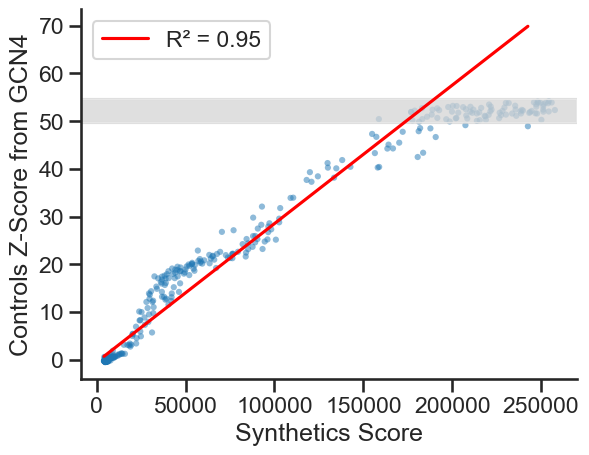

In [61]:
sns.scatterplot(data = gcn4_controls_only_syn, x = "score", y = "controls_only_z-score", alpha = 0.5, edgecolor = 'none', s = 20)
plt.xlabel("Synthetics Score")
plt.ylabel("Controls Z-Score from GCN4")

# plt.axhspan(min(gcn4_controls_only_syn["controls_only_z-score"]) - 0.5, min(gcn4_controls_only_syn["controls_only_z-score"]) + 10, color='gray', alpha=0.5)
# plt.axhspan(min(gcn4_controls_only_syn["controls_only_z-score"]) - 0.5, min(gcn4_controls_only_syn["controls_only_z-score"]) + 10, color='white', alpha=0.5)

plt.axhspan(max(gcn4_controls_only_syn["controls_only_z-score"]) - 4.5, max(gcn4_controls_only_syn["controls_only_z-score"]) + 0.5, color='gray', alpha=0.5)
plt.axhspan(max(gcn4_controls_only_syn["controls_only_z-score"]) - 4.5, max(gcn4_controls_only_syn["controls_only_z-score"]) + 0.5, color='white', alpha=0.5)


linear_region = gcn4_controls_only_syn[
    #(gcn4_controls_only_syn["controls_only_z-score"] > min(gcn4_controls_only_syn["controls_only_z-score"]) + 10) &
    (gcn4_controls_only_syn["controls_only_z-score"] < max(gcn4_controls_only_syn["controls_only_z-score"]) - 4.5)
]

#sns.scatterplot(data = linear_region, x = "score", y = "controls_only_z-score", alpha = 0.5, edgecolor = 'none', s = 20)


# Fit linear regression model to predict z-score from controls score
model = LinearRegression()
X = linear_region[["score"]].values.reshape(-1, 1)
y = linear_region["controls_only_z-score"].values
model.fit(X, y)

# Predict and evaluate
predictions = model.predict(X)
r2 = r2_score(y, predictions)

# Plot regression line
sns.lineplot(x=linear_region["score"], y = predictions, color="red", label=f"R² = {r2:.2f}")
# plt.legend()

# sns.despine()

controls_syn["gcn4_z-score"] = model.predict(controls_syn[["score"]])
synthetics_threshold = model.predict([[19350]])

sns.despine()

In [62]:
model.coef_

array([0.00029002])

In [63]:
model.intercept_

-0.48821966428938524

In [64]:
3212 * 0.00018165

0.5834598

In [65]:
min(controls_syn["score"])

3212.0

In [66]:
min(controls_syn["gcn4_z-score"])

0.4433360298944069

In [67]:
controls_syn

,seq,score,screen,gcn4_z-score
0,AAAAAIACELRTDNYFEYPDLSILDALDNDSDETMSLIDE,25075.335066,controls_syn,6.784218
1,AAAAASDHSDVNDIIELGGLSNRLYDFYSDLEDIENDIAV,42429.450978,controls_syn,11.817321
2,AAADGASFSDDTDEDLYKYDPWDLPGLSVIKTDDPEWFFF,167550.966119,controls_syn,48.105509
3,AAADGASFSDDTDEDLYKYDPWELPSKASFGEQEWYFFSP,109426.029848,controls_syn,31.247908
4,AAADGPDCDTREFCELRDSLLWNESCFLLDDDKRFDVSEN,56143.316707,controls_syn,15.794665
...,...,...,...,...
17265,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,254716.006477,controls_syn,73.385425
17266,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,237618.847801,controls_syn,68.426846
17267,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,46055.201492,controls_syn,12.868874
17268,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,141711.824042,controls_syn,40.611549


In [68]:
gcn4

,seq,score,screen,z-score
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,50849.75654,gcn4,5.133148
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,22153.46439,gcn4,0.188953
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,25911.89042,gcn4,0.836507
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,22446.77365,gcn4,0.239489
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,51501.39821,gcn4,5.245422
...,...,...,...,...
20726,AKVDTEEEDKTMVDSTSLSWEDLFDFESYSTDLIASINPD,261829.75160,gcn4,41.483704
20727,STDYTPMFEYETYEDNFKEWTSLFDNDIPVTTDDVSLADR,261410.70530,gcn4,41.411505
20728,MTDSTPMFEYELTENNSKEWTSLFDTDIPVTTDDESLADK,152798.87030,gcn4,22.698354
20729,STDSTPMFEYQNLENNSKEWTSLFDNDIPVTTDNVSLADK,113197.55830,gcn4,15.875291


Text(0.5, 1.02, '40-mer Ratio Screens')

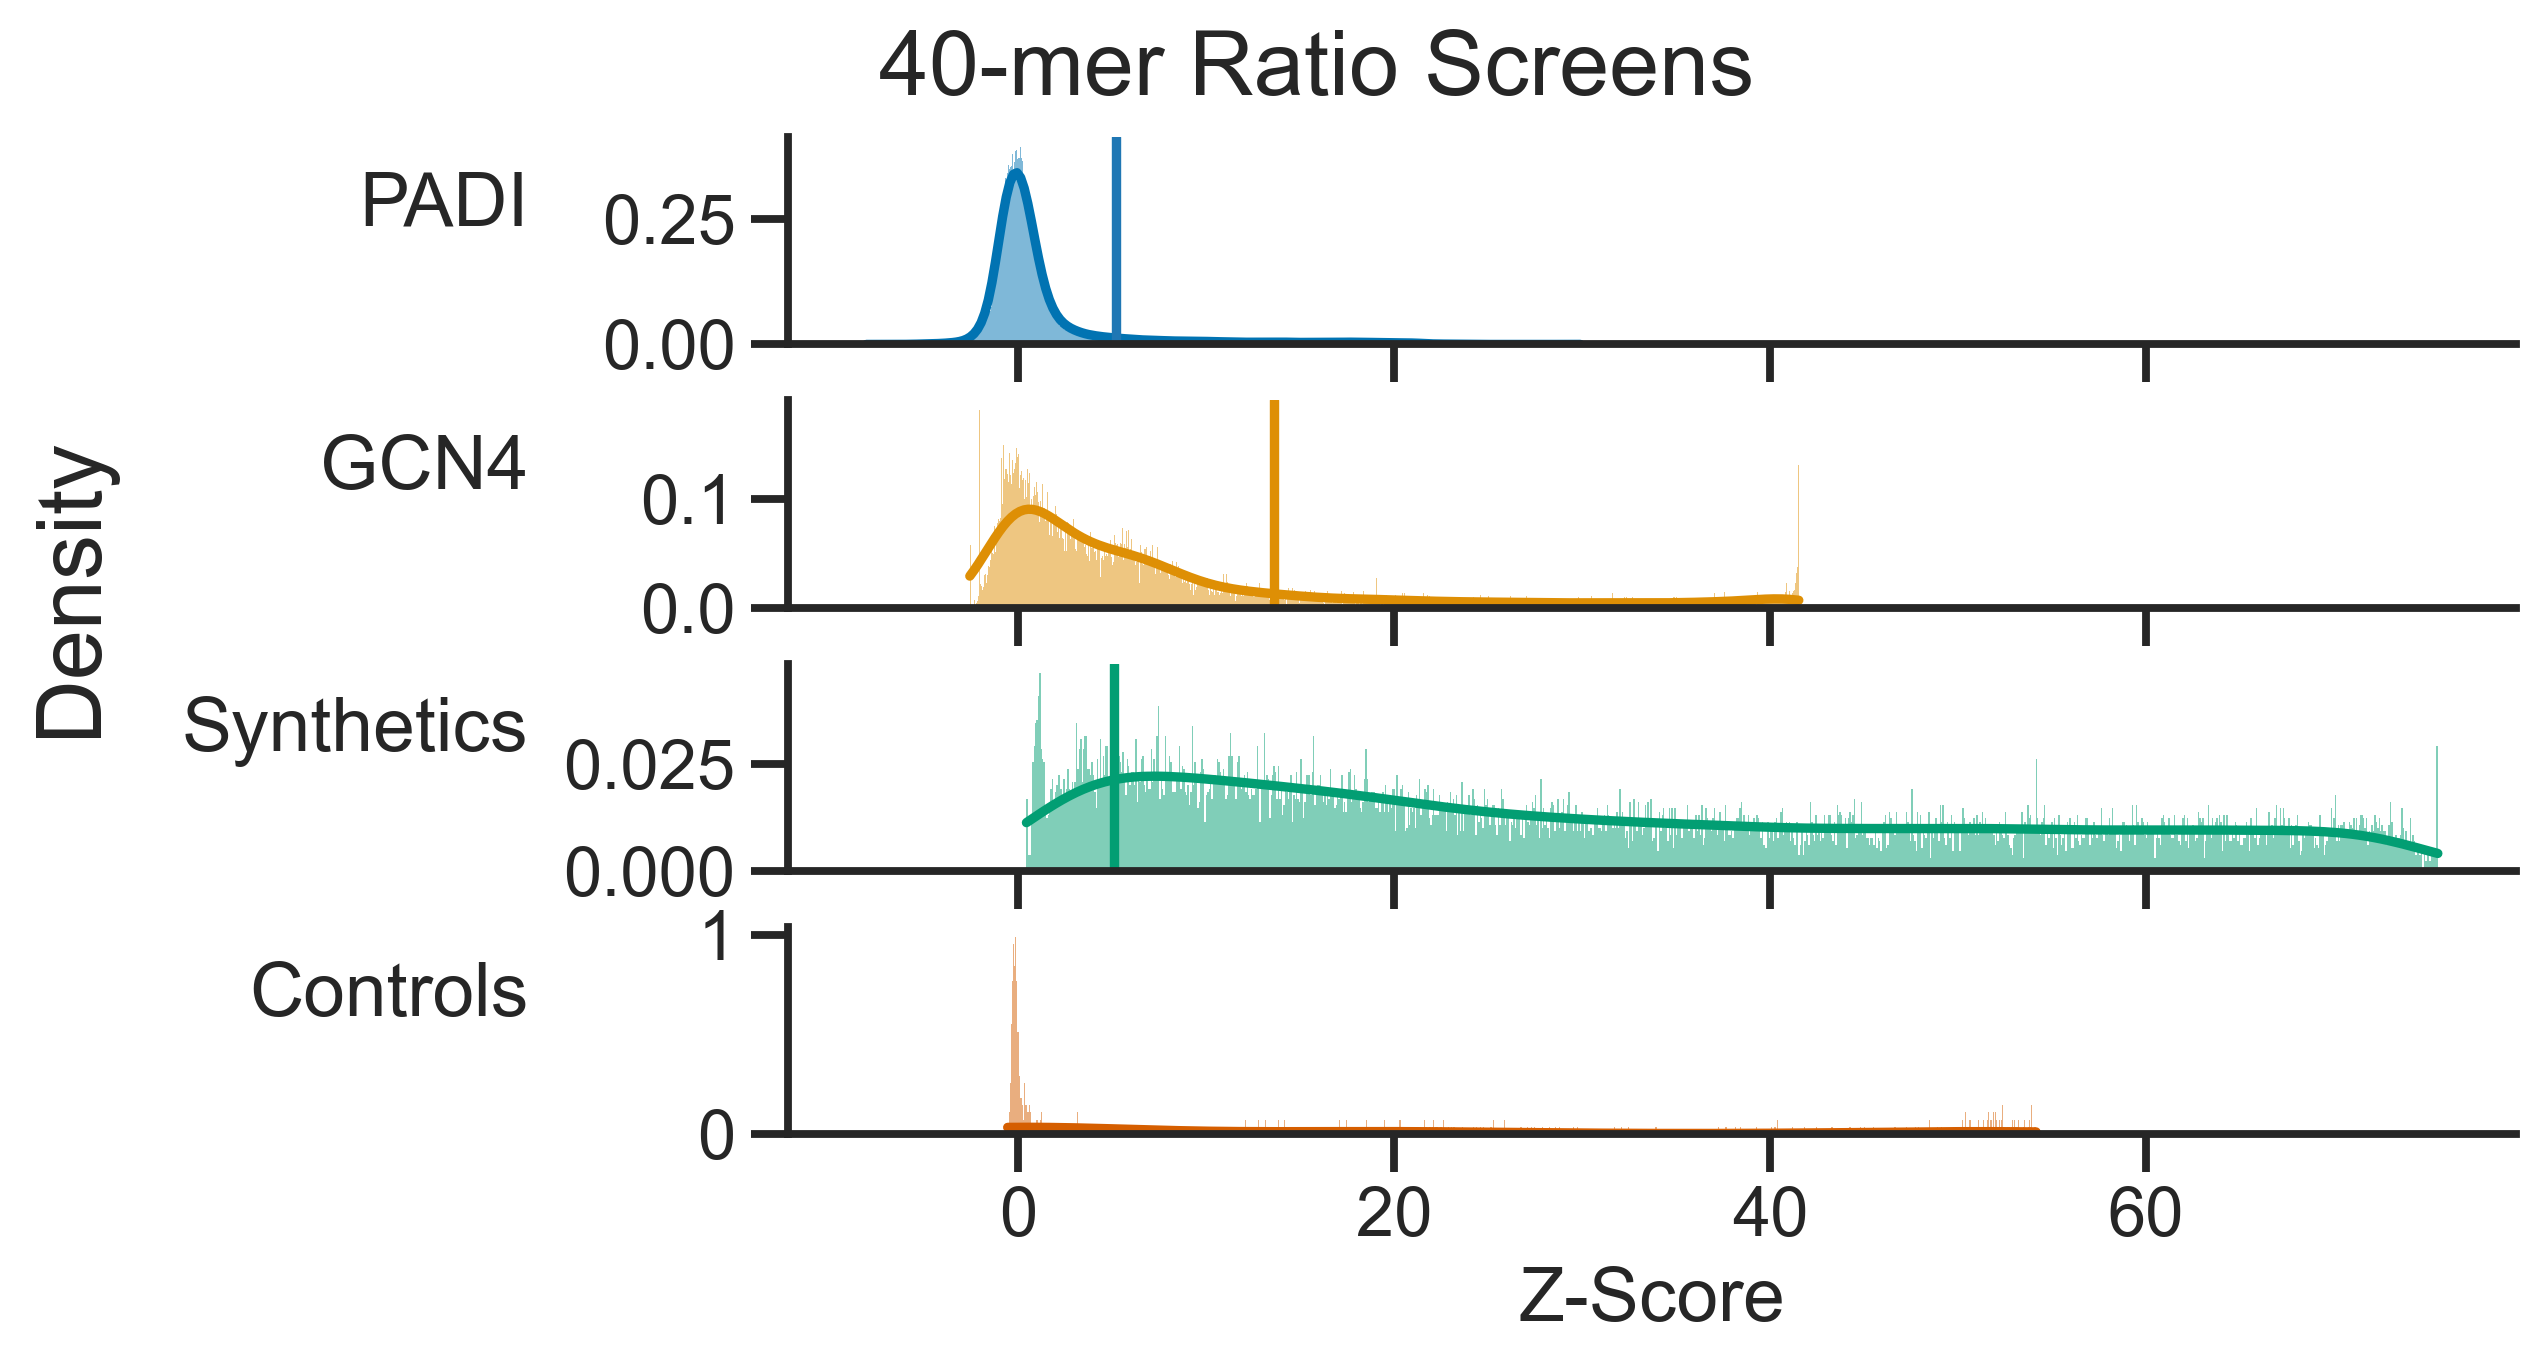

In [69]:
palette = sns.color_palette('colorblind', 4)

sns.set_context('talk')
sns.set_style('ticks')

fig, axs = plt.subplots(4, 1, sharex = True, figsize = (8, 4), dpi = 300)
sns.histplot(padi["z-score"], ax = axs[0], stat = 'density', bins = 1000, edgecolor = 'none', kde = True, color = palette[0])
sns.histplot(gcn4["z-score"], ax = axs[1], stat = 'density', bins = 1000, edgecolor = 'none', kde = True, color = palette[1])
sns.histplot(controls_syn["gcn4_z-score"], ax = axs[2], stat = 'density', bins = 1000, edgecolor = 'none', kde = True, color = palette[2])
sns.histplot(controls["gcn4_z-score"], ax = axs[3], stat = 'density', bins = 1000, edgecolor = 'none', kde = True, color = palette[3])

axs[0].set_ylabel("PADI", rotation = 0, ha = 'right')
axs[0].axvline(padi_threshold)

axs[1].set_ylabel("GCN4", rotation = 0, ha = 'right')
axs[1].axvline(gcn4_threshold, color = palette[1])

axs[2].set_ylabel("Synthetics", rotation = 0, ha = 'right')
axs[2].axvline(synthetics_threshold, color = palette[2])

axs[3].set_ylabel("Controls", rotation = 0, ha = 'right')


fig.supylabel("Density", ha = 'right', va = 'bottom', x = -0.001)

sns.despine()
fig.tight_layout(pad = 0)

for ax in axs:
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.set_xlabel("")

axs[3].set_xlabel("Z-Score")
fig.suptitle("40-mer Ratio Screens", va = 'bottom', y = 1.02)

In [70]:
# Pairplot:  Z-score comparison of shared tiles in GCN4, Synthetics, and Controls

gcn4_controls_syn = pd.merge(gcn4, controls_syn, on = "seq", suffixes = ("_gcn4", "_syn"))
gcn4_controls_syn_controls = pd.merge(gcn4_controls_syn, controls, on = "seq", suffixes = ("", "_controls"))
gcn4_controls_syn_controls = gcn4_controls_syn_controls.rename(columns = {"z-score" : "GCN4", "gcn4_z-score" : "synthetics", "gcn4_z-score_controls" : "controls"})
gcn4_controls_syn_controls

,seq,score_gcn4,screen_gcn4,GCN4,score_syn,screen_syn,synthetics,score,screen,controls
0,ASGQANANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDH,31637.98609,gcn4,1.823078,8930.519463,controls_syn,2.101841,11583.254626,controls,0.507648
1,NANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDHSAQRG,35182.01274,gcn4,2.433692,8217.768578,controls_syn,1.895127,11056.275462,controls,0.394130
2,NIAATGPAIAPSQAPAIGGPSALGQYGPNPFVPAAYHYPA,42551.71009,gcn4,3.703446,13961.152719,controls_syn,3.560844,14887.892036,controls,1.219510
3,DALSSSSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAA,13333.59766,gcn4,-1.330656,4885.459740,controls_syn,0.928679,8502.833832,controls,-0.155914
4,SSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAARQLLE,14917.38884,gcn4,-1.057778,4059.300298,controls_syn,0.689073,7776.232326,controls,-0.312433
...,...,...,...,...,...,...,...,...,...,...
474,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,17261.58387,gcn4,-0.653888,4861.135792,controls_syn,0.921624,7943.796987,controls,-0.276337
475,PPTDVSLGDELHLDGEDVAMAHADALDDADLDMLGDGDSP,32720.43454,gcn4,2.009577,6479.384414,controls_syn,1.390955,9815.370149,controls,0.126823
476,PPTDVSAGDEAHADGEDVAMAHADAADDADADMAGDGDSP,14676.81276,gcn4,-1.099228,6539.294161,controls_syn,1.408330,7573.698567,controls,-0.356061
477,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDF,262003.24940,gcn4,41.513597,249619.965442,controls_syn,71.907453,259277.072990,controls,53.864071


Text(0.5, 0.98, 'GCN4 Z-Score Normalized')

<Figure size 1920x1440 with 0 Axes>

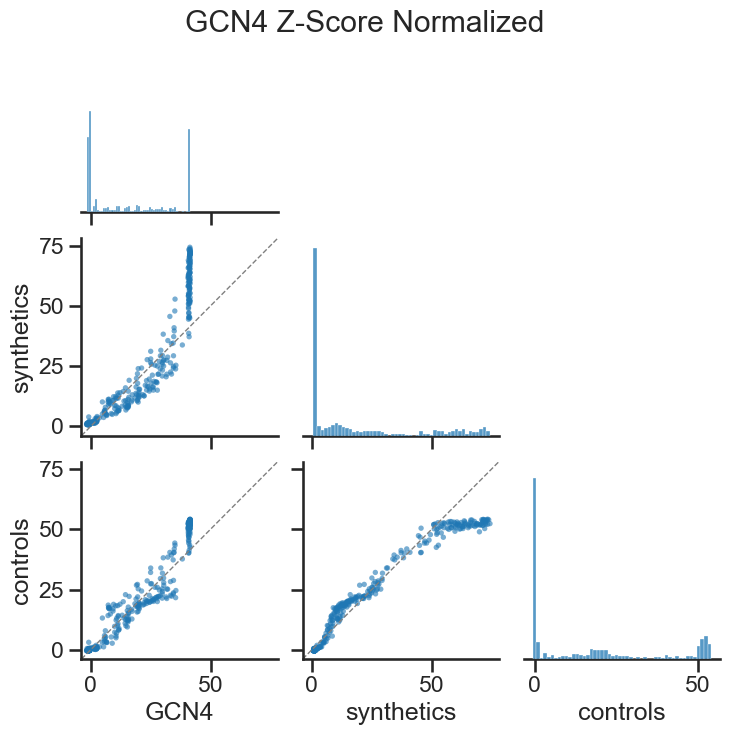

In [71]:
plt.figure(dpi = 300)

g = sns.pairplot(
    gcn4_controls_syn_controls[["GCN4", "synthetics", "controls"]],
    corner=True,
    diag_kws = {'bins' : 50},
    plot_kws={'s': 15, 'alpha': 0.6, 'edgecolor': 'none'}
)

# Function to add y=x line
def add_identity_line(*args, **kwargs):
    ax = plt.gca()
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, '--', color='gray', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

# Apply function to lower triangle (or both)
g.map_lower(add_identity_line)

plt.suptitle("GCN4 Z-Score Normalized")

# 5. Compare to sog1

In [72]:
sog1_sort2 = pd.read_csv("../data/Sog1_library1_sort2.csv")
sog1_sort2 = sog1_sort2.rename(columns = {"AAseq" : "seq"})
sog1_sort2["seq"] = sog1_sort2["seq"].str.strip().str.upper()
sog1_sort2["screen"] = "sog1_sort2"
sog1_sort2 = sog1_sort2.drop_duplicates(subset = "seq")
sog1_sort2ratio = sog1_sort2.rename(columns = {"Activity_ratio2" : "score"})
sog1_sort2ratio = sog1_sort2ratio[["seq", "score"]]
sog1_sort2ratio

,seq,score
0,EDPTWFDSGSQFILNSQQLVEALSLCDDAAGSQDREENTN,37675.082479
1,EALSLCDDLLGDQDREENDNDGDLKDKQPCIADYAHLGPE,41200.368672
2,DLAEDDEVMCMEDEVQSIQPNHERPDDGPELEHGLENGAK,30737.744889
3,GQRKRRKITPTLVNDEPVRWHKTGRTKPVMLSGVQRGCKK,50192.512730
4,SELTSTLGISHRLPQSLTPCVKTGSLQSGGLVQSVPFEEL,60000.227476
...,...,...
1107,HFNPHTDYFYTFDEYLLSTPPAIFPDLKLTSQEASEVMRS,174246.501323
1108,EDPTWFDSGDQFILNDQQLVEALSLCDDLLGSQDREENTN,243705.211234
1109,EDPTWFDSGDQAIANDQQLVEALSLCDDLLGDQDREENTN,112896.558185
1110,EDPTADAAIQQLWNQGFLFVESLSLCDDLLGAQDREENTN,230752.268974


30836.863387814807 4049.4487632251153
New threshold:
4.732282770488257


/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_18182/1832853416.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(x, norm.pdf(x, mu, sigma), 'r-', label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}', color = 'red')


,seq,score,z-score
0,EDPTWFDSGSQFILNSQQLVEALSLCDDAAGSQDREENTN,37675.082479,1.688679
1,EALSLCDDLLGDQDREENDNDGDLKDKQPCIADYAHLGPE,41200.368672,2.559239
2,DLAEDDEVMCMEDEVQSIQPNHERPDDGPELEHGLENGAK,30737.744889,-0.024477
3,GQRKRRKITPTLVNDEPVRWHKTGRTKPVMLSGVQRGCKK,50192.512730,4.779823
4,SELTSTLGISHRLPQSLTPCVKTGSLQSGGLVQSVPFEEL,60000.227476,7.201811
...,...,...,...
1107,HFNPHTDYFYTFDEYLLSTPPAIFPDLKLTSQEASEVMRS,174246.501323,35.414607
1108,EDPTWFDSGDQFILNDQQLVEALSLCDDLLGSQDREENTN,243705.211234,52.567241
1109,EDPTWFDSGDQAIANDQQLVEALSLCDDLLGDQDREENTN,112896.558185,20.264411
1110,EDPTADAAIQQLWNQGFLFVESLSLCDDLLGAQDREENTN,230752.268974,49.368548


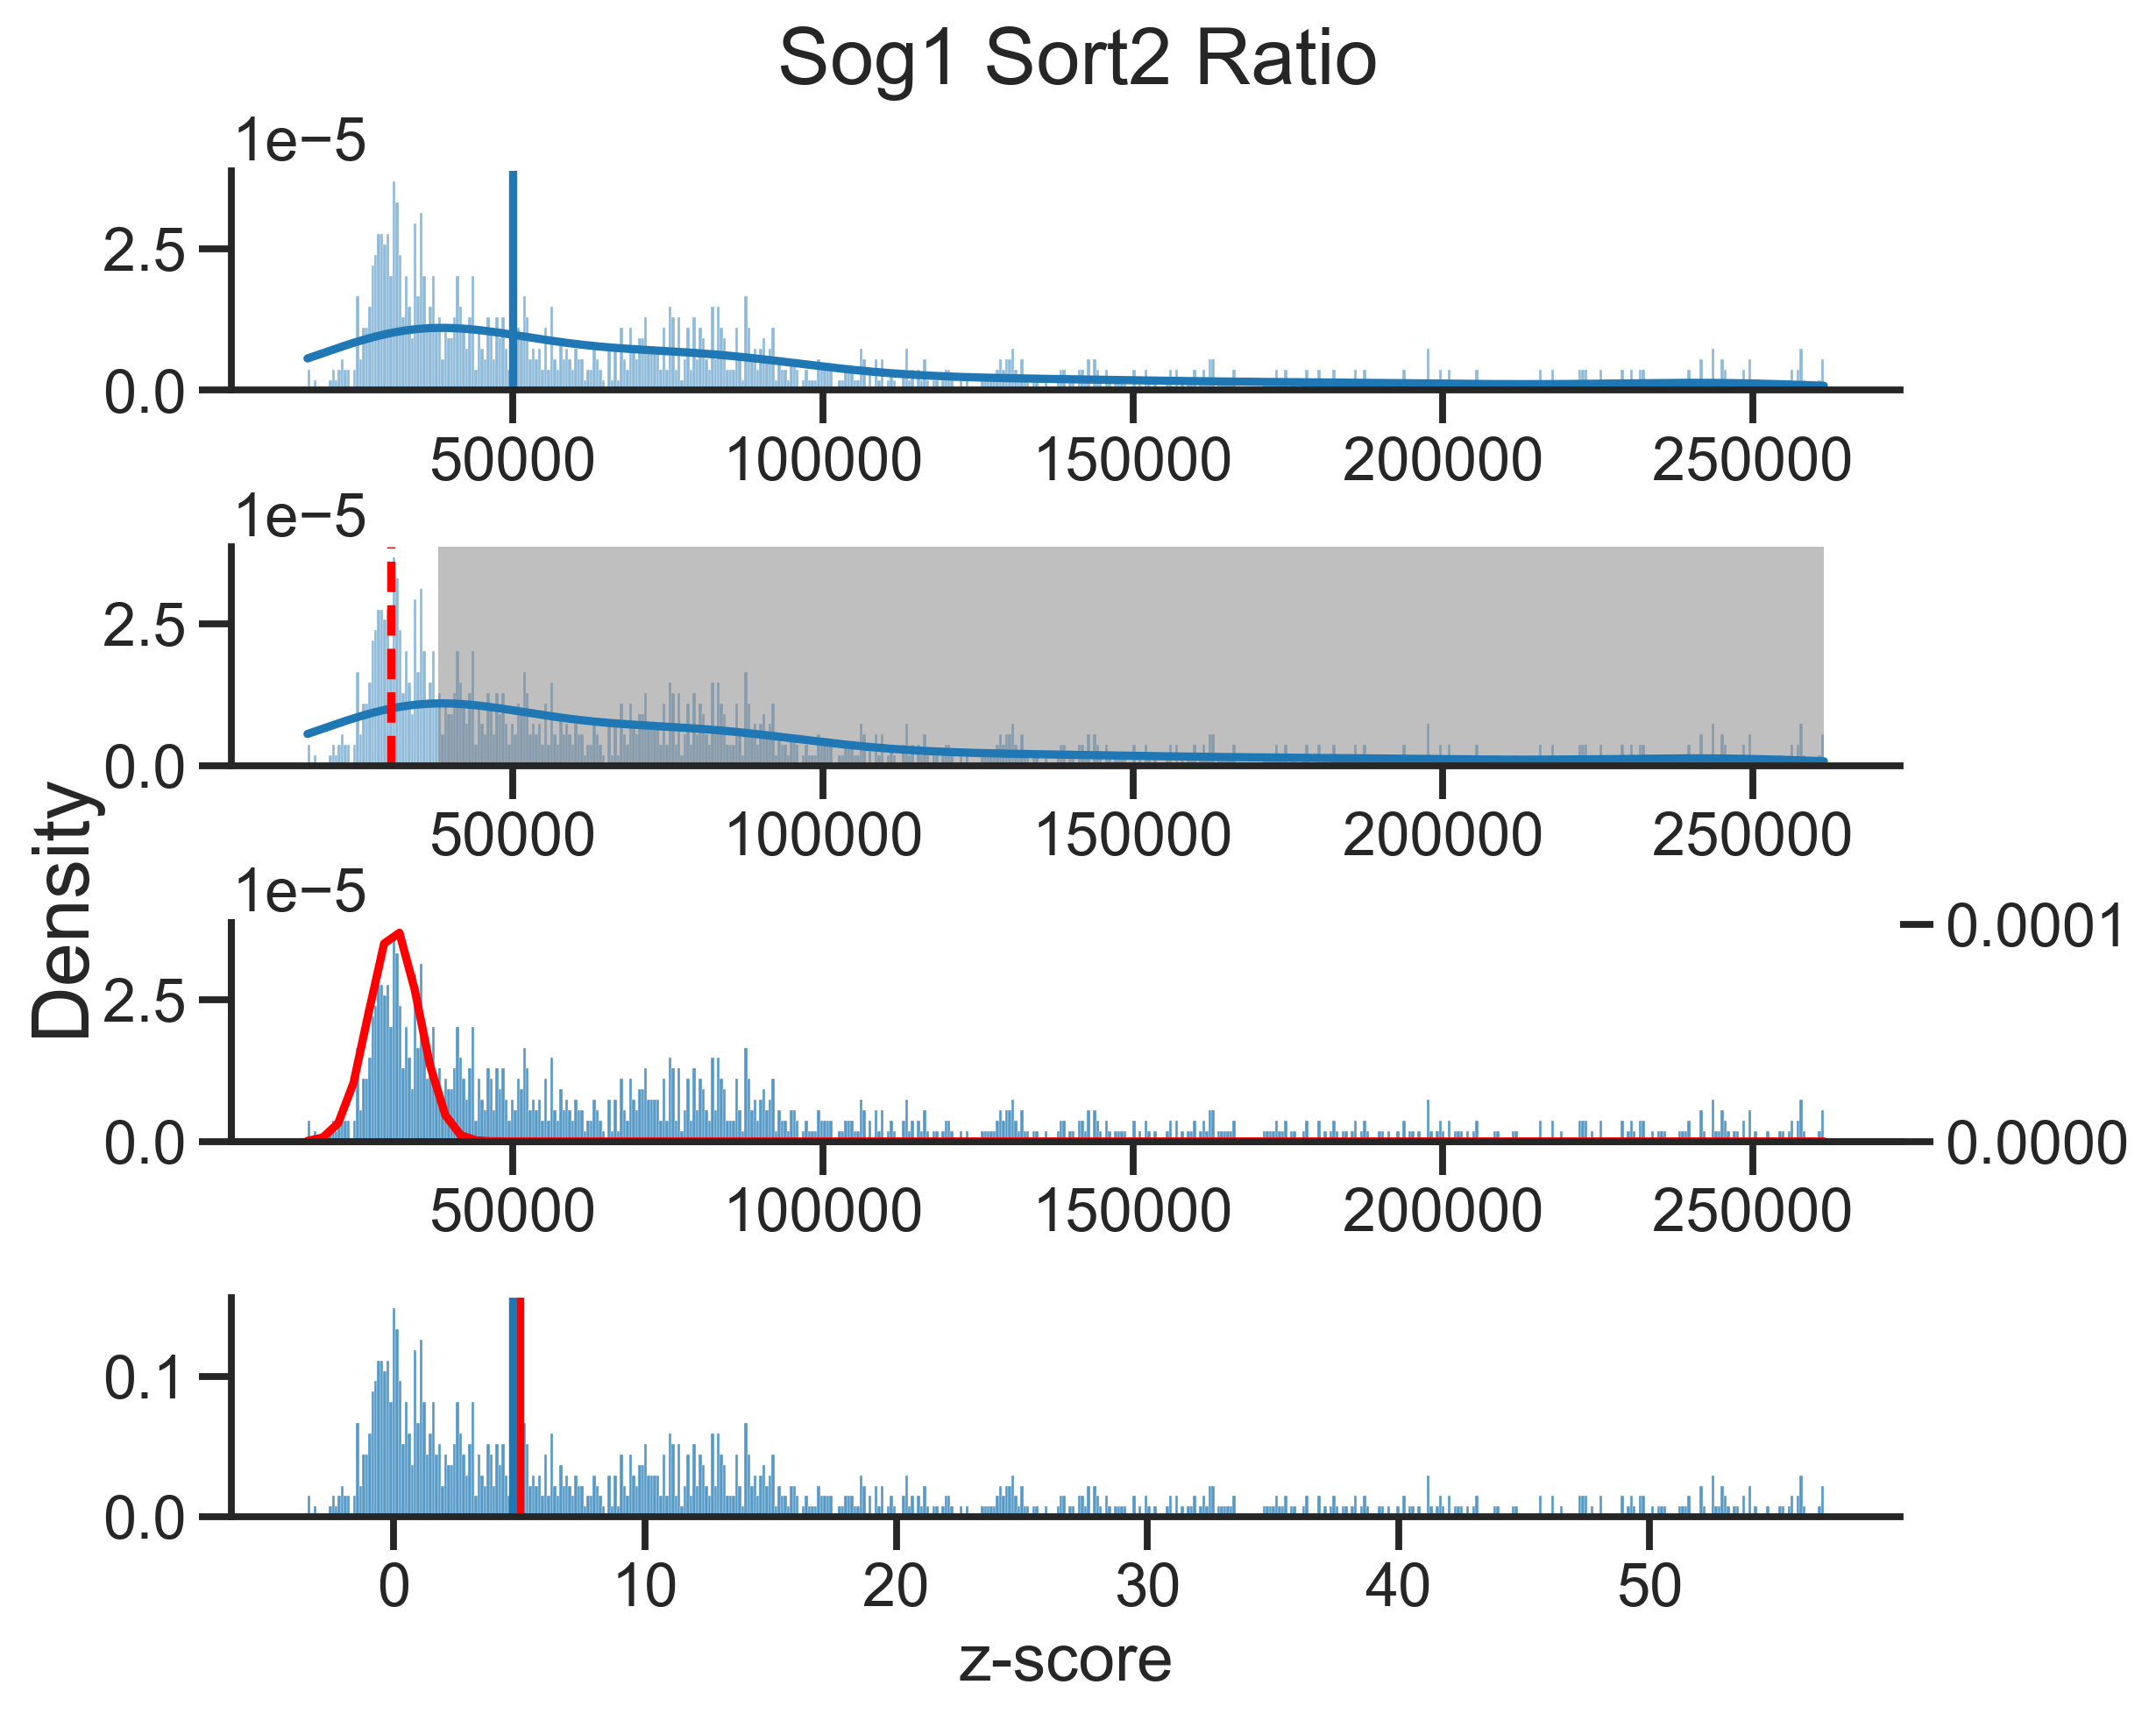

In [73]:
sog1_sort2ratio, sog1_sort2ratio_threshold = fit_inactive_gaussian_to_all_data(sog1_sort2ratio, active_threshold = 50000, title = "Sog1 Sort2 Ratio")
sog1_sort2ratio

<Axes: xlabel='z-score_padi', ylabel='z-score_sog1'>

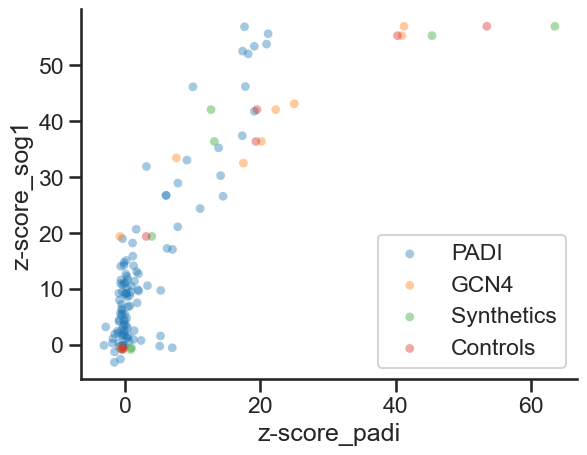

In [74]:
padi_sog1 = pd.merge(padi, sog1_sort2ratio, on = "seq", suffixes = ("_padi", "_sog1"))
sns.scatterplot(data = padi_sog1, x = "z-score_padi", y = "z-score_sog1", alpha = 0.4, edgecolor = 'none', s =  40, label = "PADI")

gcn4_sog1 = pd.merge(gcn4, sog1_sort2ratio, on = "seq", suffixes = ("_gcn4", "_sog1"))
sns.scatterplot(data = gcn4_sog1, x = "z-score_gcn4", y = "z-score_sog1", alpha = 0.4, s = 40, edgecolor = 'none', label = "GCN4")
# plt.legend()
# plt.gca().set_aspect('equal', adjustable='box')
sns.despine()

controls_syn_sog1 = pd.merge(controls_syn, sog1_sort2ratio, on = "seq", suffixes = ("_controls_syn", "_sog1"))
sns.scatterplot(data = controls_syn_sog1, x = "gcn4_z-score", y = "z-score", alpha = 0.4, s = 40, edgecolor = 'none', label = "Synthetics")
# # axs[2].legend()

# axs[2].set_xlabel("Synthetics")
# axs[2].set_ylabel("SOG1")
# # axs[2].set_aspect('equal', adjustable='box')

controls_sog1 = pd.merge(controls, sog1_sort2ratio, on = "seq", suffixes = ("controls", "_sog1"))
sns.scatterplot(data = controls_sog1, x = "gcn4_z-score", y = "z-score", alpha = 0.4, s = 40, edgecolor = 'none', label = "Controls")
# # axs[2].legend()
# axs[3].set_xlabel("Controls")
# axs[3].set_ylabel("SOG1")


# add_eq(controls_sog1["gcn4_z-score"], controls_sog1["z-score"], # axs[3])

# for ax in # axs:
#     ax.plot(controls_syn_sog1["gcn4_z-score"], controls_syn_sog1["gcn4_z-score"], color='red', linestyle='dotted', label='y = x', alpha = 0.25)
# sns.despine()

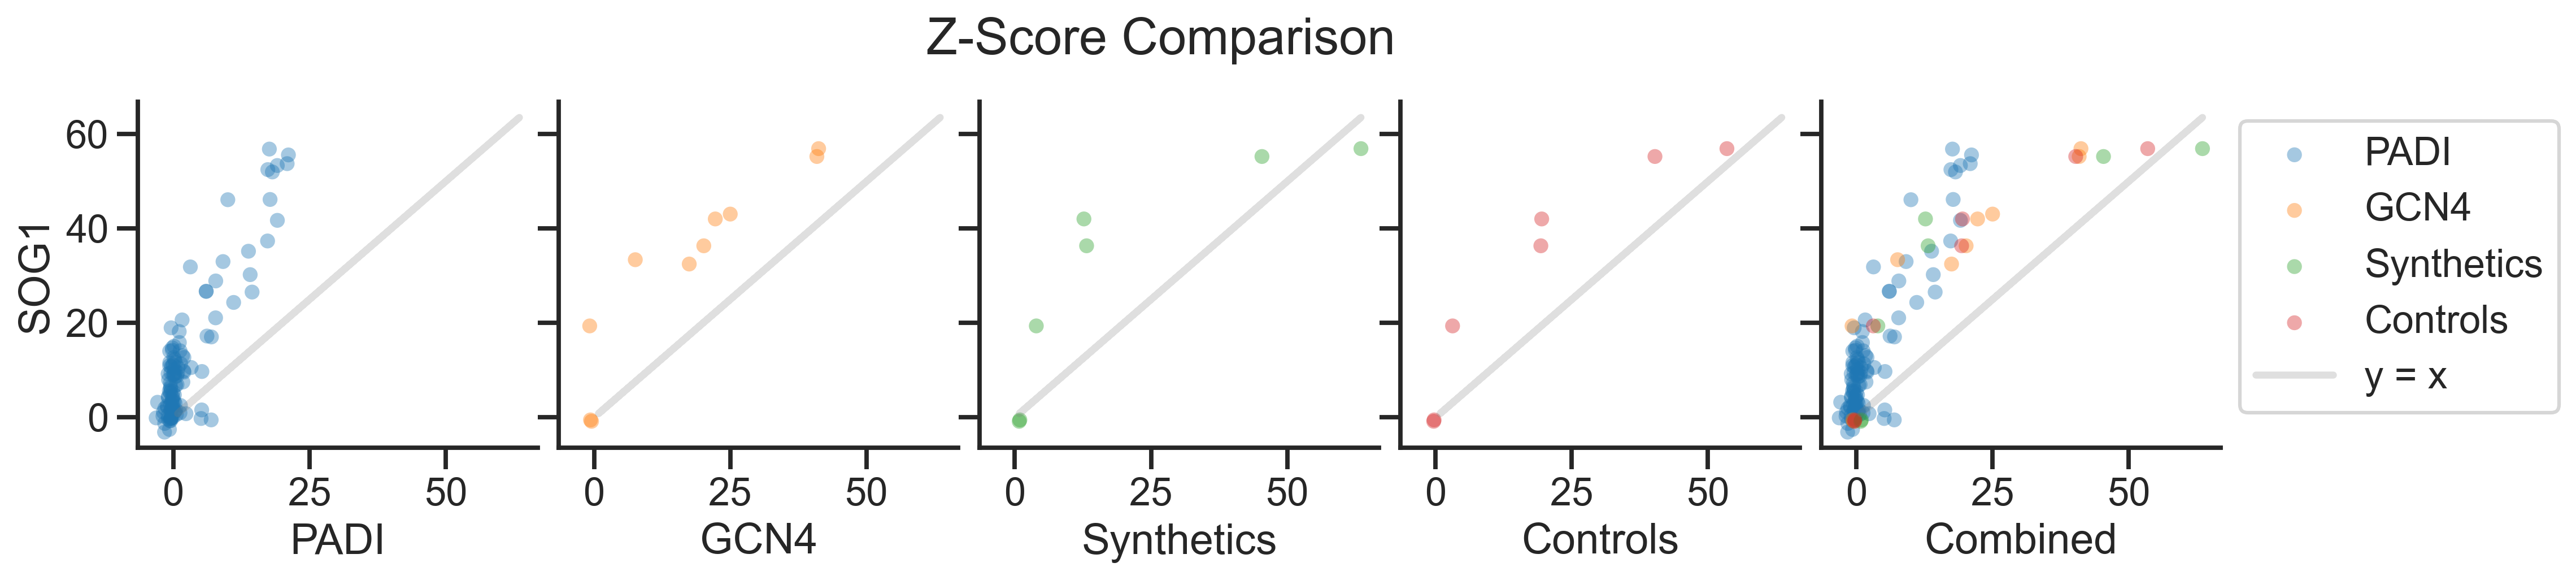

In [75]:
palette = sns.color_palette('tab10', 4)

fig, axs = plt.subplots(1, 5, figsize=(15, 3), dpi=300, sharey=True, sharex=True)

padi_sog1 = pd.merge(padi, sog1_sort2ratio, on="seq", suffixes=("_padi", "_sog1"))
sns.scatterplot(data=padi_sog1, x="z-score_padi", y="z-score_sog1", alpha=0.4, edgecolor="none", s=40, ax=axs[0], color=palette[0])
axs[0].set_xlabel("PADI")
axs[0].set_ylabel("SOG1")

gcn4_sog1 = pd.merge(gcn4, sog1_sort2ratio, on="seq", suffixes=("_gcn4", "_sog1"))
sns.scatterplot(data=gcn4_sog1, x="z-score_gcn4", y="z-score_sog1", alpha=0.4, s= 40, ax=axs[1], edgecolor="none", color=palette[1])
axs[1].set_xlabel("GCN4")

controls_syn_sog1 = pd.merge(controls_syn, sog1_sort2ratio, on="seq", suffixes=("_controls_syn", "_sog1"))
sns.scatterplot(data=controls_syn_sog1, x="gcn4_z-score", y="z-score", alpha=0.4, s= 40, ax=axs[2], edgecolor="none", color=palette[2])
axs[2].set_xlabel("Synthetics")
axs[2].set_ylabel("SOG1")

controls_sog1 = pd.merge(controls, sog1_sort2ratio, on="seq", suffixes=("controls", "_sog1"))
sns.scatterplot(data=controls_sog1, x="gcn4_z-score", y="z-score", alpha=0.4, s= 40, ax=axs[3], edgecolor="none", color=palette[3])
axs[3].set_xlabel("Controls")
axs[3].set_ylabel("SOG1")

sns.scatterplot(data = padi_sog1, x = "z-score_padi", y = "z-score_sog1", alpha = 0.4, edgecolor = 'none', s =  40, label = "PADI", ax = axs[4])
sns.scatterplot(data = gcn4_sog1, x = "z-score_gcn4", y = "z-score_sog1", alpha = 0.4, s = 40, edgecolor = 'none', label = "GCN4", ax = axs[4])
sns.scatterplot(data = controls_syn_sog1, x = "gcn4_z-score", y = "z-score", alpha = 0.4, s = 40, edgecolor = 'none', label = "Synthetics", ax = axs[4])
sns.scatterplot(data = controls_sog1, x = "gcn4_z-score", y = "z-score", alpha = 0.4, s = 40, edgecolor = 'none', label = "Controls", ax = axs[4])
axs[4].set_xlabel("Combined")

for ax in axs:
    ax.plot(controls_syn_sog1["gcn4_z-score"], controls_syn_sog1["gcn4_z-score"], color="gray", linestyle="solid", label="y = x", alpha=0.25, lw = 3)

plt.legend(bbox_to_anchor = (1,1))
plt.suptitle("Z-Score Comparison", va = 'bottom', x= 0.45)

sns.despine()
plt.tight_layout(pad = 0)

In [ ]:
padi

,seq,score,screen,z-score
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,1.004699,padi,5.203514
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,0.575876,padi,3.526685
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,-0.300407,padi,0.100141
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,0.105372,padi,1.686865
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,-0.167147,padi,0.621230
...,...,...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,-0.139281,padi,0.730194
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,-0.064551,padi,1.022412
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,-0.410777,padi,-0.331438
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,0.329820,padi,2.564526


In [79]:
gcn4

,seq,score,screen,z-score
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,50849.75654,gcn4,5.133148
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,22153.46439,gcn4,0.188953
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,25911.89042,gcn4,0.836507
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,22446.77365,gcn4,0.239489
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,51501.39821,gcn4,5.245422
...,...,...,...,...
20726,AKVDTEEEDKTMVDSTSLSWEDLFDFESYSTDLIASINPD,261829.75160,gcn4,41.483704
20727,STDYTPMFEYETYEDNFKEWTSLFDNDIPVTTDDVSLADR,261410.70530,gcn4,41.411505
20728,MTDSTPMFEYELTENNSKEWTSLFDTDIPVTTDDESLADK,152798.87030,gcn4,22.698354
20729,STDSTPMFEYQNLENNSKEWTSLFDNDIPVTTDNVSLADK,113197.55830,gcn4,15.875291


In [81]:
controls_to_merge = controls.rename(columns  = {"gcn4_z-score" : "z-score"})
controls_to_merge

,seq,score,screen,z-score
0,AAEPNYGSVAISLPLERTISSQSMERSGSSSSGSPVVLDG,8703.989803,controls,-0.112582
1,AAIALSQPETIPAKEISVPPSPAVGKSASPAPSPAPSKSG,7357.157905,controls,-0.402707
2,AAIPENELLDEDTMNAISSLKNDLSNISNSLPAEAPHEIA,14912.682565,controls,1.224850
3,AALDVALALSQPETKPAKEVSVPPSPAIRNSASPAPSPAP,8839.884407,controls,-0.083309
4,AAVVESFFSSSADSTPMFEYENLEDNSKEWTSLFDNDIPV,252224.680582,controls,52.344895
...,...,...,...,...
492,YKMQQEQNMKTFDPEVAFEEWFLSTDYQGLPSDFSPLTGV,259411.961204,controls,53.893128
493,YPSTPHPQPRLRVPVKATHRPSALQPFLAQNNPRRHSFNL,9030.547980,controls,-0.042237
494,YRSQSVSTQRRSATSGVRKRQPLPPIVVEDPSDTVAMKRA,9198.535282,controls,-0.006051
495,YSLFDSPSEGYETSPLFNTNDDLDDSNGWYSLFPPTTTSS,244362.069960,controls,50.651188


In [83]:
controls_syn_to_merge = controls_syn.rename(columns  = {"gcn4_z-score" : "z-score"})
controls_syn_to_merge

,seq,score,screen,z-score
0,AAAAAIACELRTDNYFEYPDLSILDALDNDSDETMSLIDE,25075.335066,controls_syn,6.784218
1,AAAAASDHSDVNDIIELGGLSNRLYDFYSDLEDIENDIAV,42429.450978,controls_syn,11.817321
2,AAADGASFSDDTDEDLYKYDPWDLPGLSVIKTDDPEWFFF,167550.966119,controls_syn,48.105509
3,AAADGASFSDDTDEDLYKYDPWELPSKASFGEQEWYFFSP,109426.029848,controls_syn,31.247908
4,AAADGPDCDTREFCELRDSLLWNESCFLLDDDKRFDVSEN,56143.316707,controls_syn,15.794665
...,...,...,...,...
17265,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,254716.006477,controls_syn,73.385425
17266,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,237618.847801,controls_syn,68.426846
17267,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,46055.201492,controls_syn,12.868874
17268,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,141711.824042,controls_syn,40.611549


In [85]:
all_screens = pd.concat([padi, gcn4, controls_to_merge, controls_syn_to_merge])
all_screens

,seq,score,screen,z-score
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,1.004699,padi,5.203514
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,0.575876,padi,3.526685
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,-0.300407,padi,0.100141
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,0.105372,padi,1.686865
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,-0.167147,padi,0.621230
...,...,...,...,...
17265,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,254716.006477,controls_syn,73.385425
17266,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,237618.847801,controls_syn,68.426846
17267,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,46055.201492,controls_syn,12.868874
17268,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,141711.824042,controls_syn,40.611549


In [89]:
# Group by sequence and aggregate the screen column to list all unique screens for each sequence
all_screens_agg = all_screens
all_screens_agg["screens_combined"] = all_screens.groupby("seq")["screen"].transform(lambda x: ', '.join(sorted(x.unique())))

# Drop duplicates to avoid redundant rows
all_screens_agg = all_screens_agg.drop_duplicates(subset=["seq", "screens_combined"])

all_screens_agg

,seq,score,screen,z-score,screens_combined
0,MEDQVGFGFRPNDEELVGHYLRNKIEGNTSRDVEVAISEV,1.004699,padi,5.203514,padi
1,PNDEELVGHYLRNKIEGNTSRDVEVAISEVNICSYDPWNL,0.575876,padi,3.526685,padi
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,-0.300407,padi,0.100141,padi
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,0.105372,padi,1.686865,padi
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,-0.167147,padi,0.621230,padi
...,...,...,...,...,...
17265,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,254716.006477,controls_syn,73.385425,controls_syn
17266,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,237618.847801,controls_syn,68.426846,controls_syn
17267,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,46055.201492,controls_syn,12.868874,controls_syn
17268,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,141711.824042,controls_syn,40.611549,controls_syn


In [90]:
all_screens_agg["screens_combined"].value_counts()

screens_combined
padi                            68458
gcn4                            18462
controls_syn                    16770
controls, controls_syn, gcn4      479
controls, controls_syn             18
controls_syn, gcn4                  3
Name: count, dtype: int64

In [93]:
all_screens_agg[all_screens_agg["screens_combined"] == "controls, controls_syn, gcn4"]

,seq,score,screen,z-score,screens_combined
7,ASGQANANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDH,31637.98609,gcn4,1.823078,"controls, controls_syn, gcn4"
8,NANYQAFTAGSALNGPSLPAPSLFAGHGPEAHSDHSAQRG,35182.01274,gcn4,2.433692,"controls, controls_syn, gcn4"
24,NIAATGPAIAPSQAPAIGGPSALGQYGPNPFVPAAYHYPA,42551.71009,gcn4,3.703446,"controls, controls_syn, gcn4"
57,DALSSSSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAA,13333.59766,gcn4,-1.330656,"controls, controls_syn, gcn4"
58,SSLPSTAVAQGDIQTTSTADTETKNPAQSDIAEAARQLLE,14917.38884,gcn4,-1.057778,"controls, controls_syn, gcn4"
...,...,...,...,...,...
20703,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,17261.58387,gcn4,-0.653888,"controls, controls_syn, gcn4"
20704,PPTDVSLGDELHLDGEDVAMAHADALDDADLDMLGDGDSP,32720.43454,gcn4,2.009577,"controls, controls_syn, gcn4"
20705,PPTDVSAGDEAHADGEDVAMAHADAADDADADMAGDGDSP,14676.81276,gcn4,-1.099228,"controls, controls_syn, gcn4"
20706,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDF,262003.24940,gcn4,41.513597,"controls, controls_syn, gcn4"


In [100]:
# Assign priority to sort and then keep first
all_screens["priority"] = all_screens["screen"].map({"controls_syn": 1, "gcn4": 2, "controls": 3})
all_screens = all_screens.sort_values(by = "priority")
all_screens

,seq,score,screen,z-score,screens_combined,priority
17269,YYSSLGVEPWDLDGLFEFSRLLVDLNMDGFKIDWDYEVAE,139134.166354,controls_syn,39.863967,controls_syn,1.0
5762,HLDVDLFADVEIDDPPQIDFDEVLSLVDDGQNPSSCVESF,234910.365351,controls_syn,67.641322,controls_syn,1.0
5761,HLDSSNSFDAAASGDSDDDYLFDTSVLRFSNDDDGDLYLK,25644.408028,controls_syn,6.949263,controls_syn,1.0
5760,HLDFPDMFDDALDLDAYDLGSLLSDIDSPMDFKDDMPTNY,171371.783296,controls_syn,49.213636,controls_syn,1.0
5759,HKQSVAPTTLVDLNPIITCYSEWRSTDDLKDLLLEDFIDK,230983.306573,controls_syn,66.502383,controls_syn,1.0
...,...,...,...,...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,-0.139281,padi,0.730194,padi,NaN
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,-0.064551,padi,1.022412,padi,NaN
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,-0.410777,padi,-0.331438,padi,NaN
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,0.329820,padi,2.564526,padi,NaN


In [101]:
all_screens_duplic_removed = all_screens.drop_duplicates(subset="seq", keep="first")
all_screens_duplic_removed

,seq,score,screen,z-score,screens_combined,priority
17269,YYSSLGVEPWDLDGLFEFSRLLVDLNMDGFKIDWDYEVAE,139134.166354,controls_syn,39.863967,controls_syn,1.0
5762,HLDVDLFADVEIDDPPQIDFDEVLSLVDDGQNPSSCVESF,234910.365351,controls_syn,67.641322,controls_syn,1.0
5761,HLDSSNSFDAAASGDSDDDYLFDTSVLRFSNDDDGDLYLK,25644.408028,controls_syn,6.949263,controls_syn,1.0
5760,HLDFPDMFDDALDLDAYDLGSLLSDIDSPMDFKDDMPTNY,171371.783296,controls_syn,49.213636,controls_syn,1.0
5759,HKQSVAPTTLVDLNPIITCYSEWRSTDDLKDLLLEDFIDK,230983.306573,controls_syn,66.502383,controls_syn,1.0
...,...,...,...,...,...,...
69568,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,-0.139281,padi,0.730194,padi,NaN
69569,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,-0.064551,padi,1.022412,padi,NaN
69570,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,-0.410777,padi,-0.331438,padi,NaN
69571,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,0.329820,padi,2.564526,padi,NaN


In [105]:
all_screens_duplic_removed["screens_combined"].value_counts()

screens_combined
padi                            68458
gcn4                            18462
controls_syn                    16770
controls, controls_syn, gcn4      479
controls, controls_syn             18
controls_syn, gcn4                  3
Name: count, dtype: int64

In [106]:
all_screens_duplic_removed[all_screens_duplic_removed["screens_combined"] == "controls, controls_syn, gcn4"]

,seq,score,screen,z-score,screens_combined,priority
5694,HGEAVAIGMVKEAELARFLGVLRPDAVARLAKCIASYDLP,18325.656062,controls_syn,4.826652,"controls, controls_syn, gcn4",1.0
5711,HGPKGWEGFRQDELALLQDVMENKGHGYVFSCGGGIVESP,32010.965475,controls_syn,8.795715,"controls, controls_syn, gcn4",1.0
5881,HRQTRPQVPLFSQSTGSIPKTPNMVMQDMDLFDDFTAFEG,47154.374825,controls_syn,13.187660,"controls, controls_syn, gcn4",1.0
5880,HRPSALQPFLAQNNPRRHSFSLQLQRHLQQQYPGSPVQDP,5728.058724,controls_syn,1.173052,"controls, controls_syn, gcn4",1.0
5917,HSSISGVGSHRRTKPLPPIKYDPDDPVAVKRARNTEAARK,5850.524777,controls_syn,1.208570,"controls, controls_syn, gcn4",1.0
...,...,...,...,...,...,...
11575,PTSLEITAPVPAVKAEPPVSSPVVKPVSSPARSPTAAPRS,6048.982349,controls_syn,1.266128,"controls, controls_syn, gcn4",1.0
11500,PSPSSSVDNLNDYLTDINSLAWGVNSLNDEFWTDLFMNDI,220767.013244,controls_syn,63.539417,"controls, controls_syn, gcn4",1.0
11502,PSPVQKPVETEVAVTTTSSSSRRKSGGSPASGRHSSVAGV,4700.508847,controls_syn,0.875039,"controls, controls_syn, gcn4",1.0
11522,PSTAFTNLTSPDIGESPYLDNYDQSPGIFAGDAVMASDNW,90622.682769,controls_syn,25.794494,"controls, controls_syn, gcn4",1.0


In [108]:
all_screens_duplic_removed[all_screens_duplic_removed["screens_combined"] == "controls, controls_syn"]

,seq,score,screen,z-score,screens_combined,priority
5368,GSGRSGVDGGGSDALDDFDLDMLGSDALDDFDLDMLGSDA,83651.285612,controls_syn,23.772624,"controls, controls_syn",1.0
7902,LGSDALDDFDLDMLGSDALDDFDLDMLGSDALDDFDLDML,221841.809094,controls_syn,63.851133,"controls, controls_syn",1.0
1052,DDAVVESFFSSSTDSTPMAEYENLEDNSKEWTSLFDNDIP,52687.350696,controls_syn,14.792354,"controls, controls_syn",1.0
1050,DDAVVESFFSSSTDSDPMFEYENLEDNSKEWTSLFDNDIP,118146.934176,controls_syn,33.777176,"controls, controls_syn",1.0
1049,DDAVVESFFSSSTDSAPMFEYENLEDNSKEWTSLFDNDIP,162640.474759,controls_syn,46.681351,"controls, controls_syn",1.0
1001,DALDDFDLDMLGSDALDDFDLDMLGSDALDDFDLDMLGSD,192928.217732,controls_syn,55.465510,"controls, controls_syn",1.0
14602,STDSTPMFEYENIEDNSKEWTSIFDNDIPVTTDDVSIADK,30840.351572,controls_syn,8.456209,"controls, controls_syn",1.0
14601,STDSTPMAEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,16897.628858,controls_syn,4.412491,"controls, controls_syn",1.0
14600,STDSTPMAEYENLEDNSKEWTSLADNDIPVTTDDVSLADK,6880.497452,controls_syn,1.507287,"controls, controls_syn",1.0
14597,STDSDPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,50009.283858,controls_syn,14.015651,"controls, controls_syn",1.0


In [109]:
all_screens_duplic_removed[all_screens_duplic_removed["screens_combined"] == "controls, controls_syn"]

,seq,score,screen,z-score,screens_combined,priority
5368,GSGRSGVDGGGSDALDDFDLDMLGSDALDDFDLDMLGSDA,83651.285612,controls_syn,23.772624,"controls, controls_syn",1.0
7902,LGSDALDDFDLDMLGSDALDDFDLDMLGSDALDDFDLDML,221841.809094,controls_syn,63.851133,"controls, controls_syn",1.0
1052,DDAVVESFFSSSTDSTPMAEYENLEDNSKEWTSLFDNDIP,52687.350696,controls_syn,14.792354,"controls, controls_syn",1.0
1050,DDAVVESFFSSSTDSDPMFEYENLEDNSKEWTSLFDNDIP,118146.934176,controls_syn,33.777176,"controls, controls_syn",1.0
1049,DDAVVESFFSSSTDSAPMFEYENLEDNSKEWTSLFDNDIP,162640.474759,controls_syn,46.681351,"controls, controls_syn",1.0
1001,DALDDFDLDMLGSDALDDFDLDMLGSDALDDFDLDMLGSD,192928.217732,controls_syn,55.465510,"controls, controls_syn",1.0
14602,STDSTPMFEYENIEDNSKEWTSIFDNDIPVTTDDVSIADK,30840.351572,controls_syn,8.456209,"controls, controls_syn",1.0
14601,STDSTPMAEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,16897.628858,controls_syn,4.412491,"controls, controls_syn",1.0
14600,STDSTPMAEYENLEDNSKEWTSLADNDIPVTTDDVSLADK,6880.497452,controls_syn,1.507287,"controls, controls_syn",1.0
14597,STDSDPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,50009.283858,controls_syn,14.015651,"controls, controls_syn",1.0


In [110]:
all_screens[all_screens["seq"] == "YYSSLGVEPWDLDGLFEFSRLLVDLNMDGFKIDWDYEVAE"]

,seq,score,screen,z-score,screens_combined,priority
17269,YYSSLGVEPWDLDGLFEFSRLLVDLNMDGFKIDWDYEVAE,139134.166354,controls_syn,39.863967,controls_syn,1.0


In [114]:
all_screens_duplic_removed_final = all_screens_duplic_removed[["seq", "z-score", "screen"]].reset_index(drop = True)
all_screens_duplic_removed_final

,seq,z-score,screen
0,YYSSLGVEPWDLDGLFEFSRLLVDLNMDGFKIDWDYEVAE,39.863967,controls_syn
1,HLDVDLFADVEIDDPPQIDFDEVLSLVDDGQNPSSCVESF,67.641322,controls_syn
2,HLDSSNSFDAAASGDSDDDYLFDTSVLRFSNDDDGDLYLK,6.949263,controls_syn
3,HLDFPDMFDDALDLDAYDLGSLLSDIDSPMDFKDDMPTNY,49.213636,controls_syn
4,HKQSVAPTTLVDLNPIITCYSEWRSTDDLKDLLLEDFIDK,66.502383,controls_syn
...,...,...,...
104185,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,0.730194,padi
104186,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,1.022412,padi
104187,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,-0.331438,padi
104188,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,2.564526,padi


In [115]:
all_screens_duplic_removed_final.to_csv("../output/harmonized_screens.csv")

# Following not used

In [ ]:
sog1_shared = pd.merge(gcn4_controls_syn_controls, sog1_sort2ratio, on = 'seq', suffixes = ("", "_sog1"))
sog1_shared = sog1_shared.rename(columns = {"z-score" : "sog1_ratio"})
sog1_shared

,seq,score_gcn4,screen_gcn4,GCN4,score_syn,screen_syn,synthetics,score,screen,controls,score_sog1,sog1_ratio
0,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,137982.57010,gcn4,20.145596,47109.769098,controls_syn,13.174724,98918.046571,controls,19.320682,178085.368901,36.362605
1,STIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPNNNGF,150214.68590,gcn4,22.253115,45422.092004,controls_syn,12.685257,99648.306499,controls,19.477989,201111.677406,42.048887
2,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,18345.73970,gcn4,-0.467094,4463.296310,controls_syn,0.806241,7627.523904,controls,-0.344467,27543.557030,-0.813273
3,PSPSSSVDNLNDYLTDINSLAWGVNSLNDEFWTDLFMNDI,260331.73400,gcn4,41.225605,220767.013244,controls_syn,63.539417,257484.729283,controls,53.477977,261419.548044,56.941746
4,DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP,258453.39020,gcn4,40.901978,158106.387699,controls_syn,45.366359,196155.831083,controls,40.266947,254667.274654,55.274291
5,PPTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDGDSP,16429.97458,gcn4,-0.797169,15277.058963,controls_syn,3.942487,23689.550108,controls,3.115500,109363.718111,19.391986
6,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,17261.58387,gcn4,-0.653888,4861.135792,controls_syn,0.921624,7943.796987,controls,-0.276337,28745.072808,-0.516562


In [ ]:
sog1_sort2ratio = pd.merge(sog1_sort2ratio, padi, on = 'seq')

In [ ]:
pd.merge(sog1_shared, padi, on = "seq")

,seq,score_gcn4,screen_gcn4,GCN4,score_syn,screen_syn,synthetics,score_x,screen_x,controls,score_sog1,sog1_ratio,score_y,screen_y,z-score


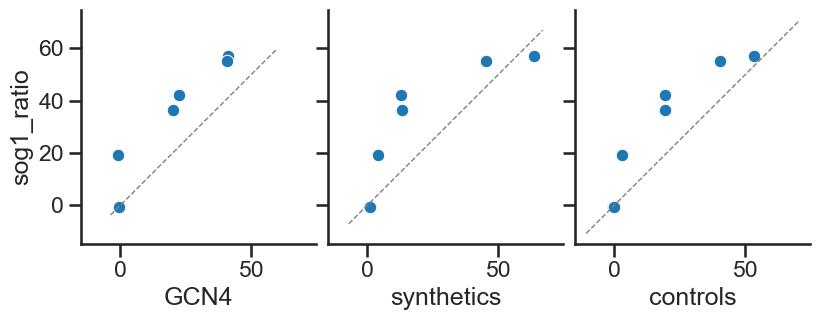

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np

x_vars = ["GCN4", "synthetics", "controls"]
y_var = "sog1_ratio"

fig, axes = plt.subplots(nrows=1, ncols=len(x_vars), sharey=True, sharex = True, figsize=(8, 3))

for ax, x_var in zip(axes, x_vars):
    x = sog1_shared[x_var]
    y = sog1_shared[y_var]

    # Regression plot
    sns.scatterplot(x=x, y=y, ax=ax)
    sns.despine()
    
    # Draw y = x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, '--', color='gray', linewidth=1)

axes[0].set_ylabel(y_var)
plt.tight_layout(pad = 0)
plt.show()


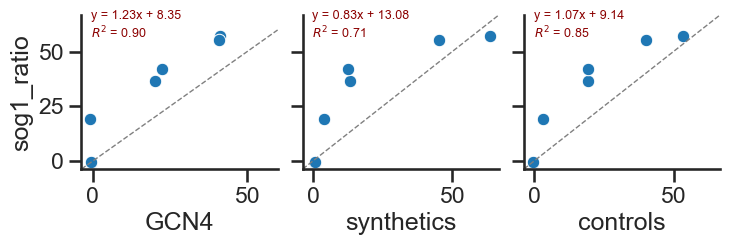

In [ ]:
g = sns.pairplot(sog1_shared[["sog1_ratio", "GCN4", "synthetics", "controls"]], 
                 x_vars=["GCN4", "synthetics", "controls"],
                 y_vars=["sog1_ratio"])

from scipy.stats import linregress

# Loop through each subplot and annotate with regression equation
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        if ax is not None:
            x_var = g.x_vars[j]
            y_var = g.y_vars[i]
            x = sog1_shared[x_var]
            y = sog1_shared[y_var]
            
            # Remove NaNs
            mask = x.notna() & y.notna()
            x_clean = x[mask]
            y_clean = y[mask]

            # Linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
            equation = f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}"

            # Add text to plot
            ax.annotate(equation,
                        xy=(0.05, 0.85),
                        xycoords='axes fraction',
                        fontsize=9,
                        color='darkred')

            # Draw y = x line
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
                np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
            ax.plot(lims, lims, '--', color='gray', linewidth=1)
            ax.set_xlim(lims)
            ax.set_ylim(lims)

In [ ]:
gcn4_sog1

,seq,score_gcn4,screen,z-score_gcn4,score_sog1,z-score_sog1
0,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,137982.57010,gcn4,20.145596,178085.368901,36.362605
1,STIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPNNNGF,150214.68590,gcn4,22.253115,201111.677406,42.048887
2,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,18345.73970,gcn4,-0.467094,27543.557030,-0.813273
3,PSPSSSVDNLNDYLTDINSLAWGVNSLNDEFWTDLFMNDI,260331.73400,gcn4,41.225605,261419.548044,56.941746
4,DDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIP,258453.39020,gcn4,40.901978,254667.274654,55.274291
5,PPTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDGDSP,16429.97458,gcn4,-0.797169,109363.718111,19.391986
6,PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP,17261.58387,gcn4,-0.653888,28745.072808,-0.516562
7,STDSTPMFEYENLENNSKEWTSLFDNDIPVTTDDVSLADK,122464.99690,gcn4,17.472014,162443.439801,32.499874
8,STDSTPMFEYEGLEDNSKEWTSLFDNDIPVTTDDVSPADK,64997.04148,gcn4,7.570638,166157.850241,33.417138
9,STDSTPMFDYDNLEDNSKDWTSLFDNDIPVTTDDVSLADK,166175.36020,gcn4,25.003041,205281.104307,43.078515


In [ ]:
controls_syn

,seq,score,screen,gcn4_z-score
0,AAAAAIACELRTDNYFEYPDLSILDALDNDSDETMSLIDE,25075.335066,controls_syn,6.784218
1,AAAAASDHSDVNDIIELGGLSNRLYDFYSDLEDIENDIAV,42429.450978,controls_syn,11.817321
2,AAADGASFSDDTDEDLYKYDPWDLPGLSVIKTDDPEWFFF,167550.966119,controls_syn,48.105509
3,AAADGASFSDDTDEDLYKYDPWELPSKASFGEQEWYFFSP,109426.029848,controls_syn,31.247908
4,AAADGPDCDTREFCELRDSLLWNESCFLLDDDKRFDVSEN,56143.316707,controls_syn,15.794665
...,...,...,...,...
17265,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,254716.006477,controls_syn,73.385425
17266,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,237618.847801,controls_syn,68.426846
17267,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,46055.201492,controls_syn,12.868874
17268,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,141711.824042,controls_syn,40.611549


In [ ]:
controls_syn_sog1 = pd.merge(controls_syn, sog1_sort2ratio, on = "seq", suffixes = ("_controls_syn", "_sog1"))
sns.scatterplot(data = controls_syn_sog1, x = "gcn4_z-score", y = "z-score", alpha = 0.45)
plt.plot(controls_syn_sog1["gcn4_z-score"], controls_syn_sog1["gcn4_z-score"], color='red', linestyle='solid', label='y = x')
plt.legend()
plt.xlabel("Synthetics")
plt.ylabel("SOG1")
plt.gca().set_aspect('equal', adjustable='box')
sns.despine()


ValueError: Could not interpret value `z-score` for `y`. An entry with this name does not appear in `data`.

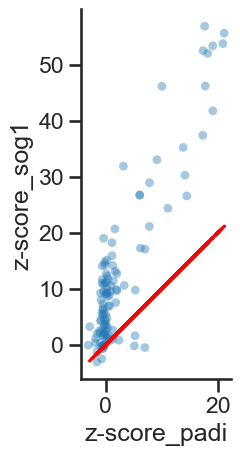

In [ ]:
sog1_sort2gfp = sog1_sort2.rename(columns = {"Activity_GFP8" : "score"})
sog1_sort2gfp = sog1_sort2gfp[["seq", "score"]]
sog1_sort2gfp

,seq,score
0,EDPTWFDSGSQFILNSQQLVEALSLCDDAAGSQDREENTN,636.156202
1,EALSLCDDLLGDQDREENDNDGDLKDKQPCIADYAHLGPE,602.696194
2,DLAEDDEVMCMEDEVQSIQPNHERPDDGPELEHGLENGAK,381.502348
3,GQRKRRKITPTLVNDEPVRWHKTGRTKPVMLSGVQRGCKK,347.155741
4,SELTSTLGISHRLPQSLTPCVKTGSLQSGGLVQSVPFEEL,437.694050
...,...,...
1107,HFNPHTDYFYTFDEYLLSTPPAIFPDLKLTSQEASEVMRS,4444.689683
1108,EDPTWFDSGDQFILNDQQLVEALSLCDDLLGSQDREENTN,7960.852191
1109,EDPTWFDSGDQAIANDQQLVEALSLCDDLLGDQDREENTN,2769.615372
1110,EDPTADAAIQQLWNQGFLFVESLSLCDDLLGAQDREENTN,5603.789064


<Axes: xlabel='score', ylabel='Count'>

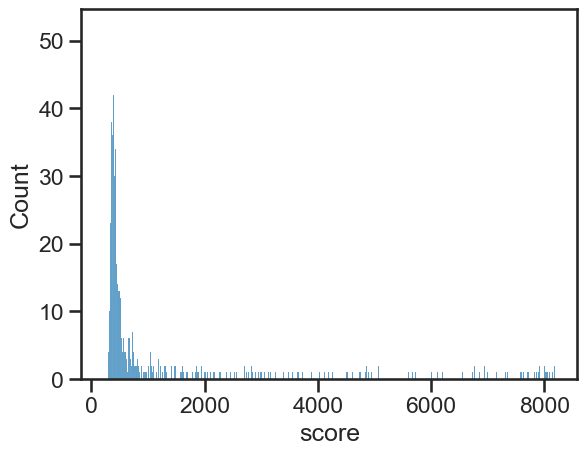

In [ ]:
sns.histplot(data = sog1_sort2gfp, x= 'score', bins = 1000)

402.58768304225214 48.5536370869777
New threshold:
1021.4973644118618


/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_18182/1832853416.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(x, norm.pdf(x, mu, sigma), 'r-', label=f'Gaussian Fit\nμ={mu:.2f}, σ={sigma:.2f}', color = 'red')


,seq,score,z-score
0,EDPTWFDSGSQFILNSQQLVEALSLCDDAAGSQDREENTN,636.156202,4.810526
1,EALSLCDDLLGDQDREENDNDGDLKDKQPCIADYAHLGPE,602.696194,4.121391
2,DLAEDDEVMCMEDEVQSIQPNHERPDDGPELEHGLENGAK,381.502348,-0.434269
3,GQRKRRKITPTLVNDEPVRWHKTGRTKPVMLSGVQRGCKK,347.155741,-1.141664
4,SELTSTLGISHRLPQSLTPCVKTGSLQSGGLVQSVPFEEL,437.694050,0.723043
...,...,...,...
1107,HFNPHTDYFYTFDEYLLSTPPAIFPDLKLTSQEASEVMRS,4444.689683,83.250241
1108,EDPTWFDSGDQFILNDQQLVEALSLCDDLLGSQDREENTN,7960.852191,155.668349
1109,EDPTWFDSGDQAIANDQQLVEALSLCDDLLGDQDREENTN,2769.615372,48.750780
1110,EDPTADAAIQQLWNQGFLFVESLSLCDDLLGAQDREENTN,5603.789064,107.122796


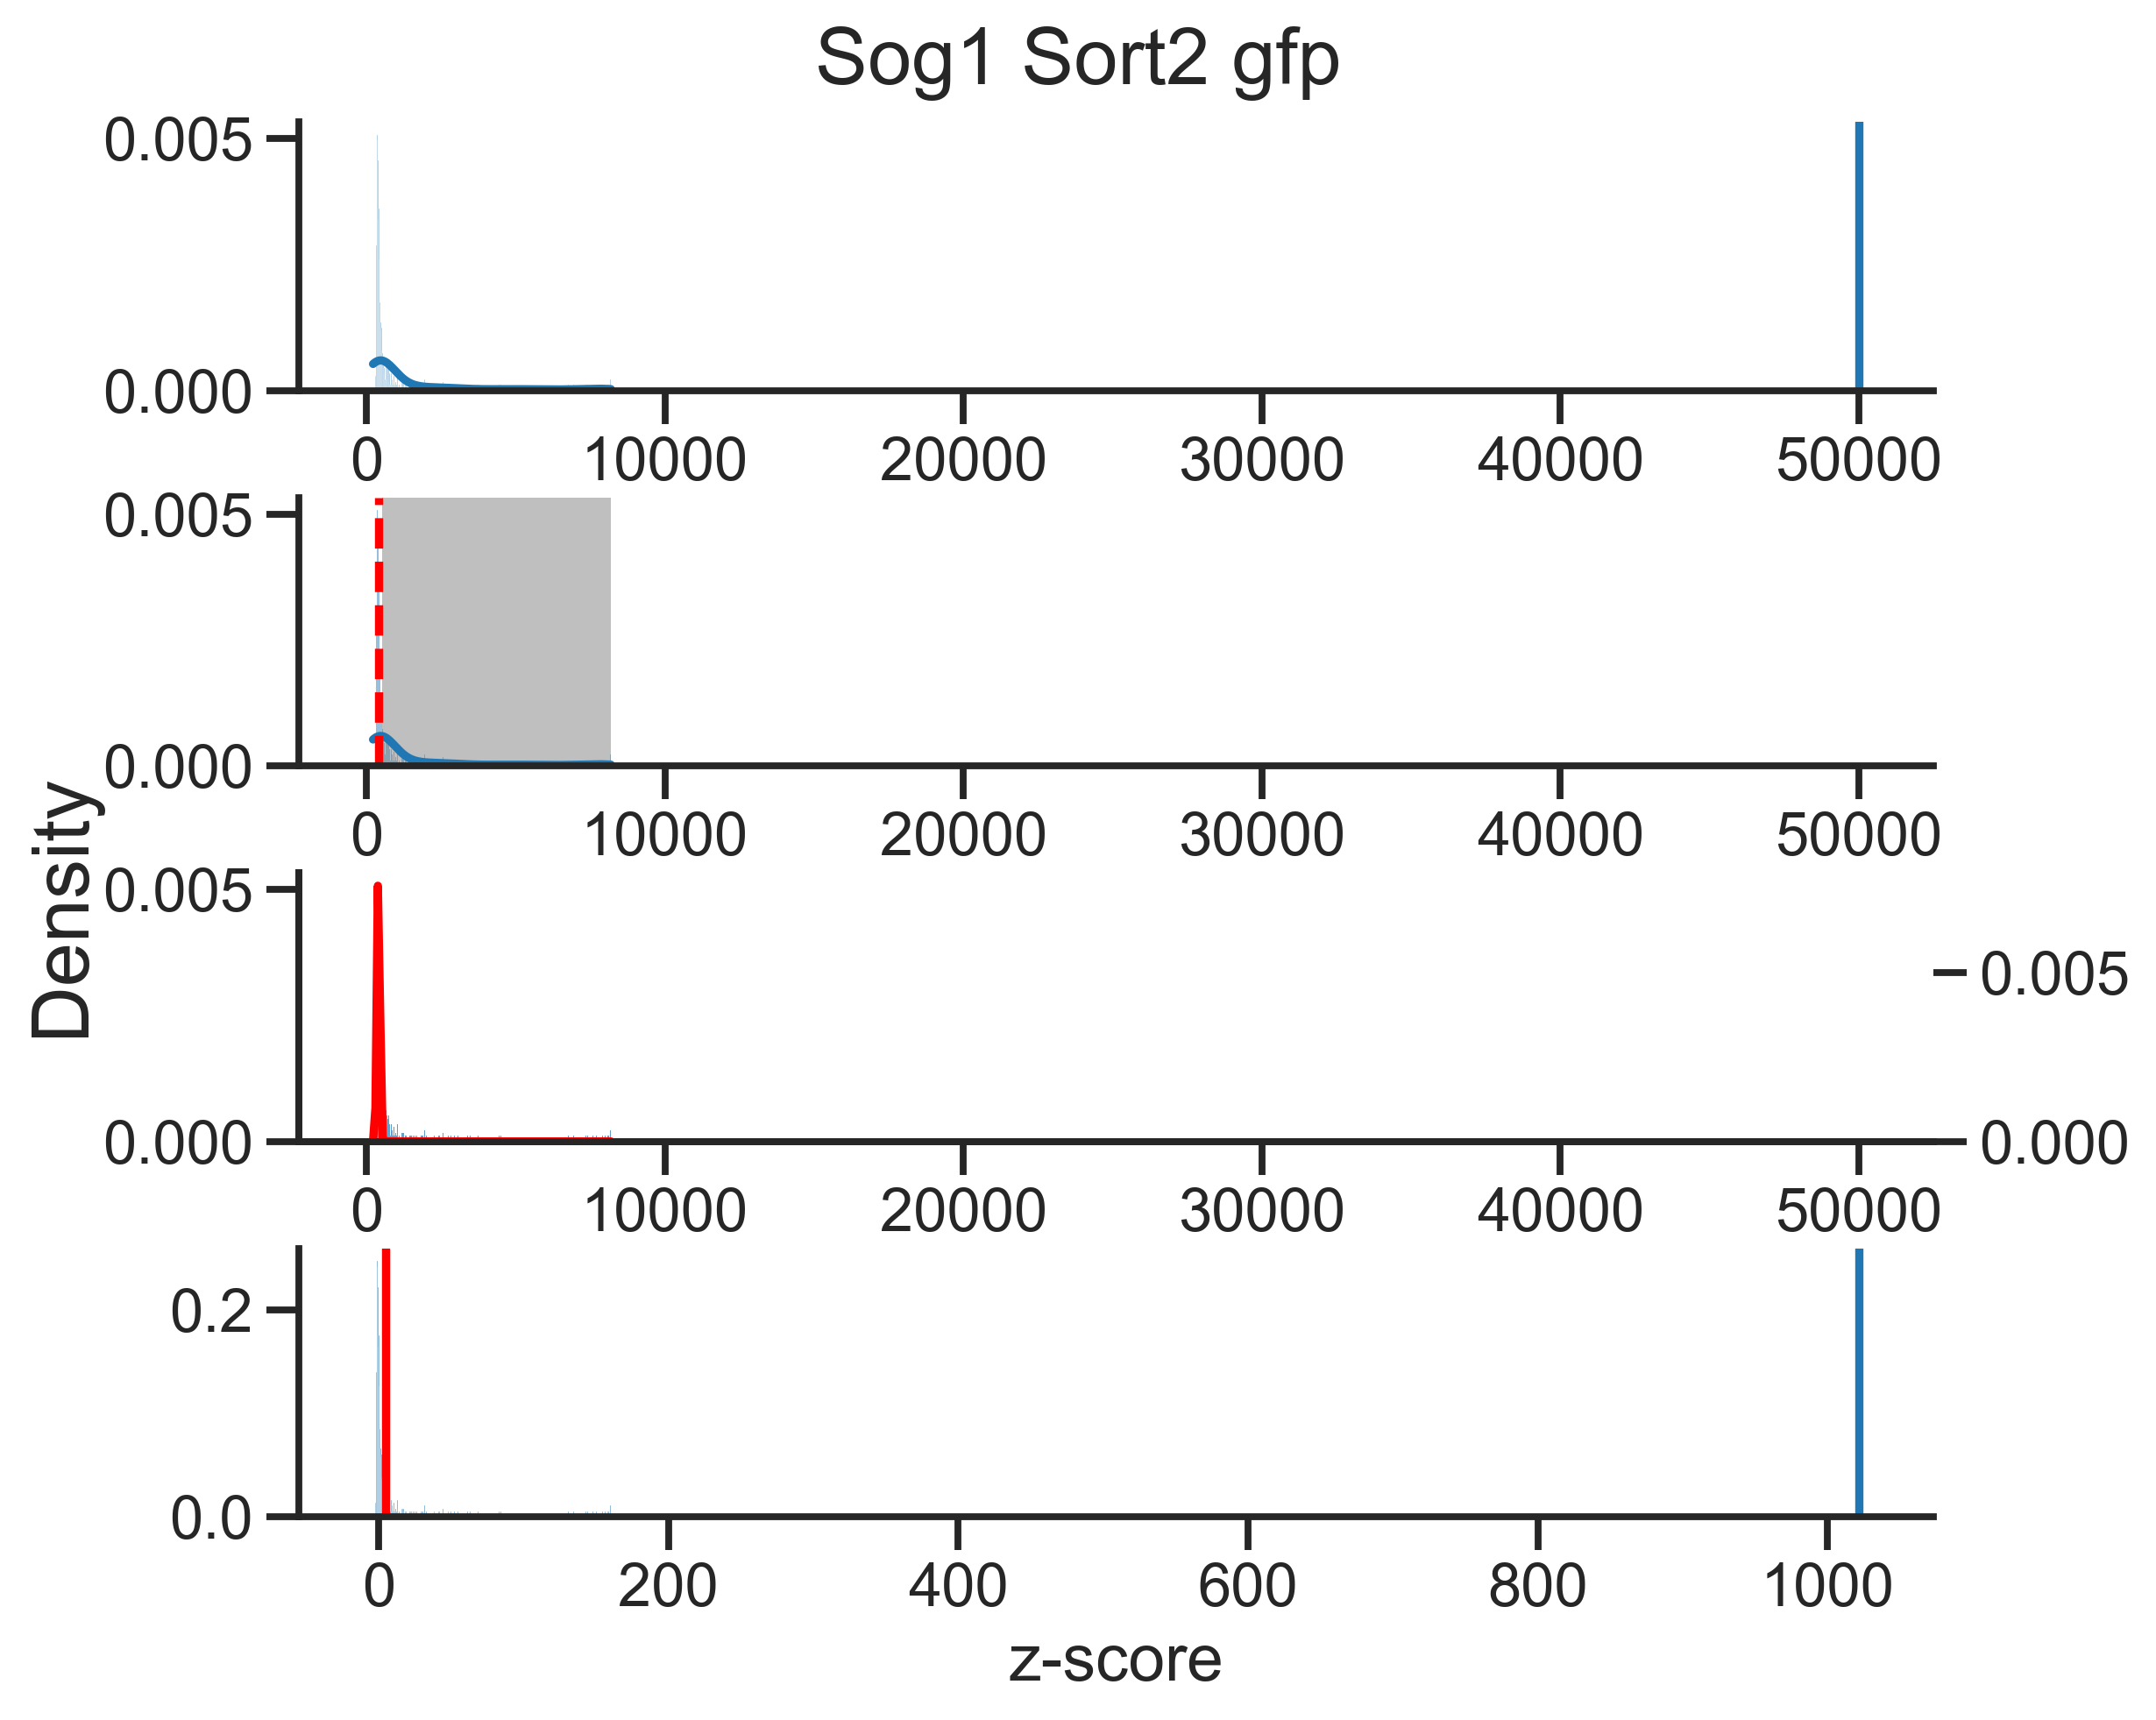

In [ ]:
sog1_sort2gfp, sog1_sort2gfp_threshold = fit_inactive_gaussian_to_all_data(sog1_sort2gfp, active_threshold = 50000, title = "Sog1 Sort2 gfp")
sog1_sort2gfp